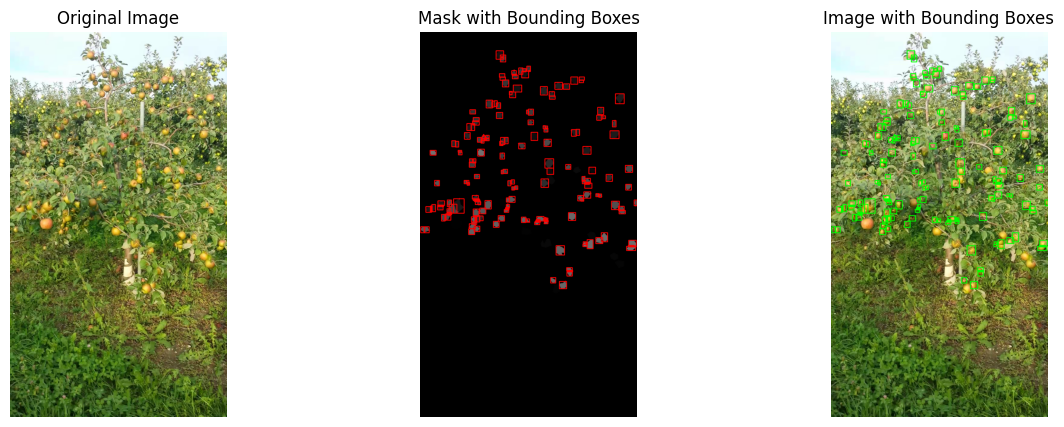

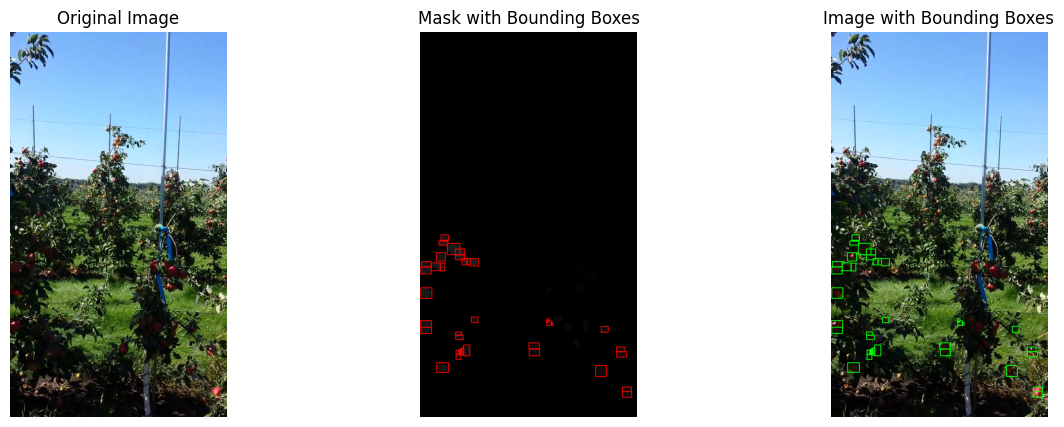

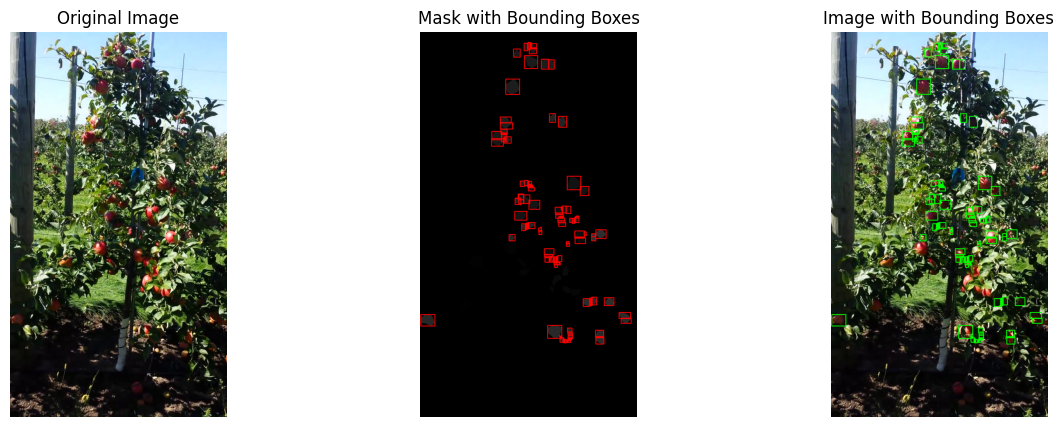

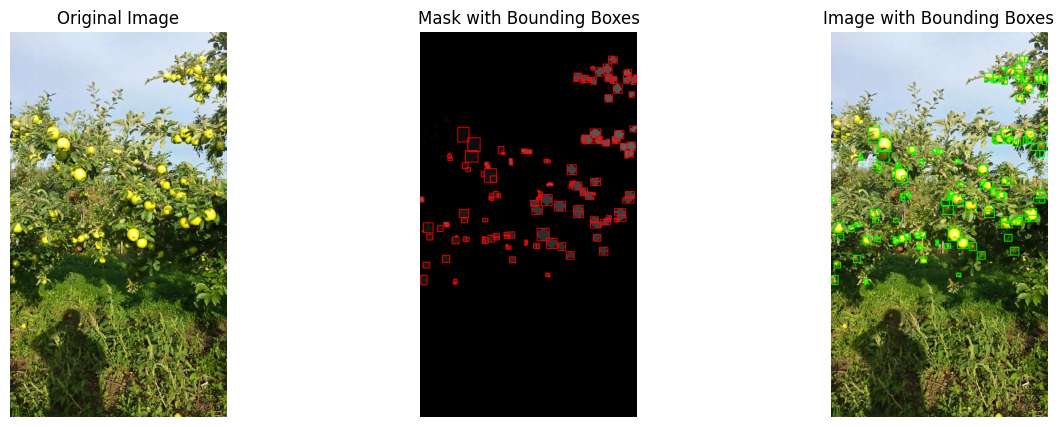

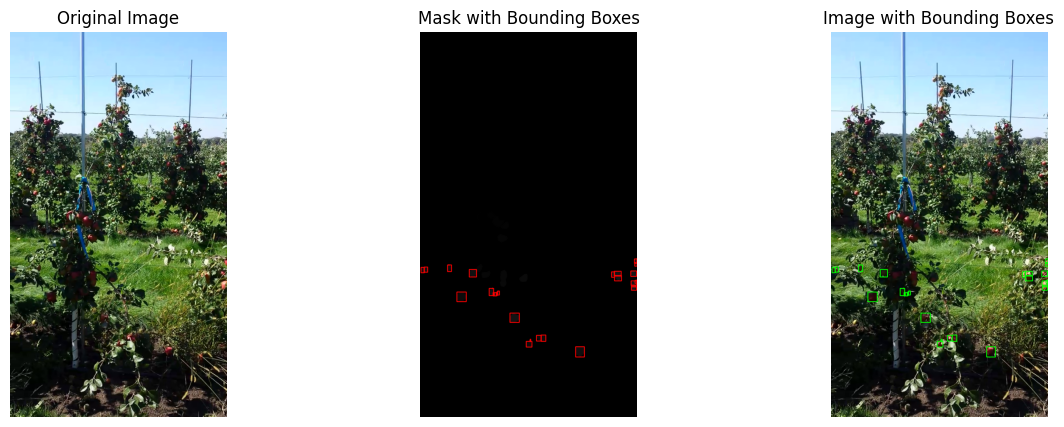

In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from glob import glob
from skimage.morphology import remove_small_objects
from scipy import ndimage
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage.measure import regionprops

def apply_nms(boxes, iou_threshold=0.5):
    """
    Applies Non-Maximum Suppression (NMS) to a list of boxes.
    Boxes are in (x, y, w, h) format.
    """
    if not boxes: # Input list of boxes is empty, return an empty list
        return []
    
    scores = [1.0] * len(boxes)  # Assign a uniform confidence score
    boxes_list = [list(box) for box in boxes]
    
    indices = cv2.dnn.NMSBoxes(boxes_list, scores, score_threshold=0.0, nms_threshold=iou_threshold)
    
    if len(indices) == 0:
        return []
    
    try:
        indices = [i[0] for i in indices]
    except:
        indices = list(indices)
    
    filtered_boxes = [boxes_list[i] for i in indices]
    return filtered_boxes
    

def masks_to_boxes(mask_path, min_object_size=1):
    """
    Converts a grayscale mask (numpy array) into a list of bounding boxes.
    Each bounding box is returned in (x, y, w, h) format.
    """
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # Reads the grayscale version of the mask image.
    if mask is None:
        raise ValueError(f"Could not load image from {mask_path}")
    
    # Threshold to binary
    _, bin_mask = cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY) # All pixel values > 10 become white (255), rest are black.
    bin_mask_bool = (bin_mask > 0)
    
    # Remove small objects
    cleaned_mask = remove_small_objects(bin_mask_bool, min_size=min_object_size)
    
    # Compute distance transform and find local maxima
    dist = ndimage.distance_transform_edt(cleaned_mask)
    local_max_coords = peak_local_max(dist, footprint=np.ones((3, 3)), labels=cleaned_mask)
    
    local_max_mask = np.zeros(dist.shape, dtype=bool)
    local_max_mask[tuple(local_max_coords.T)] = True
    
    markers, _ = ndimage.label(local_max_mask)
    
    # Apply watershed to segment overlapping objects
    labels_ws = watershed(-dist, markers, mask=cleaned_mask)
    
    boxes = []
    for region in regionprops(labels_ws):
        # region.bbox returns (min_row, min_col, max_row, max_col)
        min_row, min_col, max_row, max_col = region.bbox
        w = max_col - min_col
        h = max_row - min_row
        
        if w <= 0 or h <= 0:
            continue
        
        boxes.append((min_col, min_row, w, h))
    
    filtered_boxes = apply_nms(boxes)
    return filtered_boxes


def draw_bounding_boxes(image, boxes, color=(0, 255, 0)):
    """
    Draw bounding boxes on an image.
    
    :param image: Input image (numpy array).
    :param boxes: List of bounding boxes [(x, y, width, height), ...].
    :param color: Bounding box color.
    :return: Image with bounding boxes drawn.
    """
    img_copy = image.copy()
    for (x, y, w, h) in boxes:
        cv2.rectangle(img_copy, (x, y), (x + w, y + h), color, 2)
    return img_copy


def visualize_results(image_path, mask_path, boxes):
    """
    Display:
    1. Original image with bounding boxes.
    2. Segmentation mask with bounding boxes.
    3. Side-by-side comparison.

    :param image_path: Path to original image.
    :param mask_path: Path to segmentation mask.
    :param boxes: Extracted bounding boxes.
    """
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Could not load image {image_path}")
        return
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        print(f"Warning: Could not load mask {mask_path}")
        return

    image_with_boxes = draw_bounding_boxes(image, boxes)
    mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    mask_with_boxes = draw_bounding_boxes(mask_rgb, boxes, color=(255, 0, 0))

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(mask_with_boxes)
    axes[1].set_title("Mask with Bounding Boxes")
    axes[1].axis("off")

    axes[2].imshow(image_with_boxes)
    axes[2].set_title("Image with Bounding Boxes")
    axes[2].axis("off")

    plt.show()


# ------------------------------
# Corrected usage example
# ------------------------------

# Correctly assign directories:
# - mask_directory should point to the folder with segmentation masks.
# - image_directory should point to the folder with original images.
mask_directory = "/kaggle/input/cv-a3q2/Q2/detection/train/masks"
image_directory = "/kaggle/input/cv-a3q2/Q2/detection/train/images"

# Get the first 5 mask file paths.
mask_paths = glob(os.path.join(mask_directory, "*.png"))[:5]

for mask_path in mask_paths:
    file_name = os.path.basename(mask_path)
    
    # Assume that the image and mask have the same filename.
    image_path = os.path.join(image_directory, file_name)
    
    # Extract bounding boxes
    boxes = masks_to_boxes(mask_path)
    
    # Visualize only if there are boxes
    if boxes:
        visualize_results(image_path, mask_path, boxes)


In [ ]:
class FruitDetectionDataset(Dataset):
    def __init__(self, image_dir, mask_dir, file_list=None, transform=None, augment=False):
        """
        Args:
            image_dir (str): Directory containing images.
            mask_dir (str): Directory containing corresponding masks.
            file_list (list, optional): List of filenames to use. If None, all images in image_dir are used.
            transform (callable, optional): Transformation for images.
            augment (bool): If True, apply data augmentation(Flips, color jitter).
        """
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        if file_list is not None:
            self.image_files = file_list
        else:
            self.image_files = sorted(os.listdir(image_dir))
        self.augment = augment
        self.transform = transform
        
        # Color jitter applied to images only (used for augmentation)
        self.color_jitter = ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1) if self.augment else None

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        filename = self.image_files[idx]
        image_path = os.path.join(self.image_dir, filename)
        mask_path = os.path.join(self.mask_dir, filename)
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        if self.augment:
            image, mask = self.apply_geometric_transforms(image, mask)
            image = self.color_jitter(image)
        if self.transform:
            image = self.transform(image)
        else:
            image = ToTensor()(image)
        mask_np = np.array(mask)
        boxes = masks_to_boxes(mask_path)
        # Convert boxes from (x, y, w, h) to (x1, y1, x2, y2)
        boxes_converted = [[x, y, x + w, y + h] for (x, y, w, h) in boxes]
        
        # Ensure boxes tensor has shape [N, 4] even when empty
        if len(boxes_converted) == 0:
            boxes_tensor = torch.zeros((0, 4), dtype=torch.float32)
            labels_tensor = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes_tensor = torch.as_tensor(boxes_converted, dtype=torch.float32)
            labels_tensor = torch.ones((boxes_tensor.shape[0],), dtype=torch.int64)
        
        target = {
            "boxes": boxes_tensor,
            "labels": labels_tensor,
            "image_id": torch.tensor([idx])
        }
        return image, target

    def apply_geometric_transforms(self, image, mask):
        # Random horizontal flip
        if random.random() < 0.5:
            image = ImageOps.mirror(image)
            mask = ImageOps.mirror(mask)
        # Random vertical flip
        if random.random() < 0.5:
            image = ImageOps.flip(image)
            mask = ImageOps.flip(mask)
        # Random rotation by 0, 90, 180, or 270 degrees
        angle = random.choice([0, 90, 180, 270])
        if angle != 0:
            image = image.rotate(angle, expand=True)
            mask = mask.rotate(angle, expand=True)
        return image, mask

In [5]:
def get_faster_rcnn_resnet34(num_classes):
    """
    Constructs a Faster R-CNN model using a ResNet-34 backbone.
    Modifications/Configuration details:
    • Backbone: Uses a pre-trained ResNet-34 model. The classification head 
      (average pooling and fully connected layers) is removed so that only the
      convolutional feature extractor is used.
    • Feature Map: The backbone returns feature maps with 512 channels (from the 
      last convolutional block).
    • Anchor Generator: Configured with custom anchor sizes and aspect ratios that 
      are better suited for fruit detection. For example, fruits are typically near-
      square, so we set anchor sizes to (32, 64, 128) and aspect ratios to (0.8, 1.0, 1.25).
    • Normalization: The built-in transform of Faster R-CNN applies normalization using
      ImageNet mean and standard deviation. If needed, you can override these values.
    • Training Configuration: The model outputs and training hyperparameters (e.g., 
      learning rate, weight decay) should be set up in the training loop. Here we set the 
      maximum number of detections per image to 100.
    Args:
        num_classes (int): Number of classes (including background). For fruit detection,
                           if you have one fruit class, use num_classes=2 (1 fruit + background).
    Returns:
        model (FasterRCNN): The constructed Faster R-CNN model.
    """
    resnet = resnet34(pretrained=True)
    backbone = nn.Sequential(*list(resnet.children())[:-2])
    backbone.out_channels = 512
    # Define an AnchorGenerator with custom sizes and aspect ratios for fruit detection.
    # These values can be tuned based on the expected fruit sizes in your dataset.
    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128),),  
        aspect_ratios=((0.8, 1.0, 1.25),) 
    )
    # Standard RoIAlign with output size 7x7.
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],output_size=7,sampling_ratio=2)
    model = FasterRCNN(backbone,num_classes=num_classes,rpn_anchor_generator=anchor_generator,box_roi_pool=roi_pooler,box_detections_per_img=1000) 
    return model
    
num_classes = 2  # class 0: background, class 1: fruit
model = get_faster_rcnn_resnet34(num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 219MB/s]


In [8]:

print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
       

In [7]:
def collate_fn(batch):
    return tuple(zip(*batch))

def iou(boxA, boxB):
    
    # Boxes are expected in [x1, y1, x2, y2] format
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    
    interArea = max(0, xB - xA) * max(0, yB - yA)
    
    if interArea == 0:
        return 0.0
    
    boxAArea = (boxA[2]-boxA[0]) * (boxA[3]-boxA[1])
    boxBArea = (boxB[2]-boxB[0]) * (boxB[3]-boxB[1])
    
    return interArea / float(boxAArea + boxBArea - interArea)


def compute_map(predictions, ground_truths, iou_threshold=0.5):
    """
    Computes the mean Average Precision (mAP) at a given IoU threshold.

    Args:
        predictions (list): List of predicted results. Each element contains 'boxes' and 'scores'.
        ground_truths (list): List of ground truth results. Each element contains 'boxes'.
        iou_threshold (float): IoU threshold to consider a match (default: 0.5).

    Returns:
        float: mAP value.
    """
    # To store the average precision for each image 
    all_ap = []
    for pred, gt in zip(predictions, ground_truths):
        pred_boxes = pred['boxes'].cpu().numpy() if len(pred['boxes']) > 0 else np.array([])
        pred_scores = pred['scores'].cpu().numpy() if len(pred['scores']) > 0 else np.array([])
        gt_boxes = gt['boxes'].cpu().numpy() if len(gt['boxes']) > 0 else np.array([])
        if len(pred_boxes) == 0:
            # No predictions for this image
            continue
        # Sort the predictions by confidence scores
        sorted_indices = np.argsort(pred_scores)[::-1]  # Sort in descending order
        pred_boxes = pred_boxes[sorted_indices]
        pred_scores = pred_scores[sorted_indices]
        # To store true positives (TP) and false positives (FP) for the PR curve
        tps = []
        fps = []
        detected_gt = set()  # Track which ground truth boxes have been detected
        for pb in pred_boxes:
            match_found = False
            for j, gb in enumerate(gt_boxes):
                if j in detected_gt:
                    continue  # Skip if the ground truth box has already been detected
                if iou(pb, gb) >= iou_threshold:
                    tps.append(1)
                    fps.append(0)
                    detected_gt.add(j)
                    match_found = True
                    break
            if not match_found:
                tps.append(0)
                fps.append(1)
        # Convert TP and FP to cumulative sums for precision and recall
        tps = np.cumsum(tps)
        fps = np.cumsum(fps)
        # Compute precision and recall at each threshold
        precision = tps / (tps + fps) if (tps + fps).all() != 0 else 0
        recall = tps / len(gt_boxes) if len(gt_boxes) > 0 else np.zeros_like(tps)
        # Calculate Average Precision (AP) as the area under the PR curve using trapezoidal rule
        # Interpolate precision to create a smooth curve
        recall_points = np.linspace(0, 1, 101)  # 101 points from recall 0 to 1
        precision_at_recall = np.interp(recall_points, recall, precision)
        ap = np.trapz(precision_at_recall, recall_points)  # Trapezoidal integration
        all_ap.append(ap)
    # Compute mean Average Precision (mAP)
    mAP = np.mean(all_ap) if all_ap else 0.0
    return mAP
    
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10):
    model.train()
    total_loss = 0.0
    # Wrap the data_loader enumeration with tqdm for progress monitoring
    pbar = tqdm(enumerate(data_loader), total=len(data_loader), desc=f"Epoch {epoch} Training")
    for i, (images, targets) in pbar:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        total_loss += losses.item()
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        # Update tqdm progress bar with the current loss
        if i % print_freq == 0:
            pbar.set_postfix(loss=f"{losses.item():.4f}")
    
    avg_loss = total_loss / len(data_loader)
    return avg_loss
def validate(model, data_loader, device):
    model.eval()
    all_predictions = []
    all_ground_truths = []
    # Wrap the data_loader with tqdm for progress monitoring during validation
    pbar = tqdm(data_loader, total=len(data_loader), desc="Validation")
    with torch.no_grad():
        for images, targets in pbar:
            images = [img.to(device) for img in images]
            preds = model(images)
            all_predictions.extend(preds)
            all_ground_truths.extend(targets)
    return all_predictions, all_ground_truths

IOU_THRESHOLD = 0.5
TRAIN_DATASET_IMAGE_PATH = r'/kaggle/input/cv-a3q2/Q2/detection/train/images'
TRAIN_DATASET_MASK_PATH = r'/kaggle/input/cv-a3q2/Q2/detection/train/masks'
TEST_DATASET_IMAGE_PATH = r'/kaggle/input/cv-a3q2/Q2/detection/test/images'
all_files = sorted(os.listdir(TRAIN_DATASET_IMAGE_PATH))
split_ratio = 0.8
num_train = int(len(all_files) * split_ratio)
train_files = all_files[:num_train]
val_files   = all_files[num_train:]
transform = Compose([ToTensor()])
train_dataset = FruitDetectionDataset(TRAIN_DATASET_IMAGE_PATH, TRAIN_DATASET_MASK_PATH,file_list=train_files,transform=transform, augment=True)
val_dataset   = FruitDetectionDataset(TRAIN_DATASET_IMAGE_PATH, TRAIN_DATASET_MASK_PATH,file_list=val_files,transform=transform, augment=False)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2  
model = get_faster_rcnn_resnet34(num_classes)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 5
for epoch in range(num_epochs):
    print(f"--- Epoch {epoch} ---")
    
    train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
    
    train_preds, train_gts = validate(model, train_loader, device)
    train_map = compute_map(train_preds, train_gts, iou_threshold=IOU_THRESHOLD)
    
    val_preds, val_gts = validate(model, val_loader, device)
    val_map = compute_map(val_preds, val_gts, iou_threshold=IOU_THRESHOLD)

    print(f"Epoch [{epoch}] Train Loss: {train_loss:.4f} | Train mAP: {train_map:.4f}")
    print(f"Epoch [{epoch}] Validation mAP: {val_map:.4f}")

--- Epoch 0 ---


Validation: 100%|██████████| 17/17 [00:23<00:00,  1.40s/it]


Epoch [0] Train Loss: 1.0918 | Train mAP: 0.0035
Epoch [0] Validation mAP: 0.0031
--- Epoch 1 ---


Validation: 100%|██████████| 17/17 [00:23<00:00,  1.38s/it]


Epoch [1] Train Loss: 1.0773 | Train mAP: 0.0025
Epoch [1] Validation mAP: 0.0027
--- Epoch 2 ---


Validation: 100%|██████████| 17/17 [00:23<00:00,  1.38s/it]


Epoch [2] Train Loss: 0.9399 | Train mAP: 0.0033
Epoch [2] Validation mAP: 0.0030
--- Epoch 3 ---


Validation: 100%|██████████| 17/17 [00:23<00:00,  1.36s/it]


Epoch [3] Train Loss: 0.9150 | Train mAP: 0.0035
Epoch [3] Validation mAP: 0.0043
--- Epoch 4 ---


Validation: 100%|██████████| 17/17 [00:22<00:00,  1.35s/it]


Epoch [4] Train Loss: 0.9669 | Train mAP: 0.0036
Epoch [4] Validation mAP: 0.0043


Validation: 100%|██████████| 17/17 [00:23<00:00,  1.36s/it]



--- Evaluation at IoU = 0.3 ---
Mean Average Precision (mAP) at IoU 0.3: 0.0218
Average Precision (AP) at IoU 0.3: 0.0573


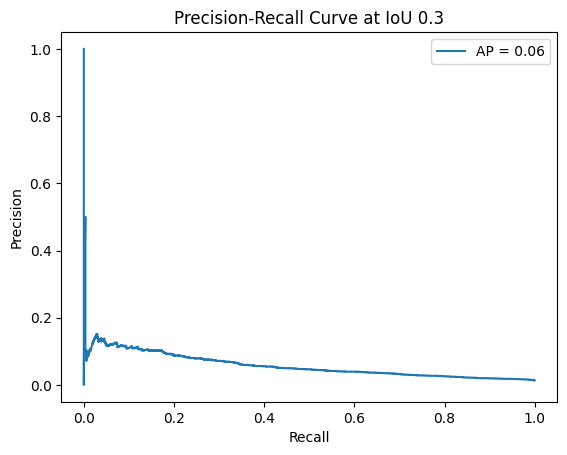

Total False Positives at IoU 0.3: 63265
Total False Negatives at IoU 0.3: 8015

--- Evaluation at IoU = 0.5 ---
Mean Average Precision (mAP) at IoU 0.5: 0.0043
Average Precision (AP) at IoU 0.5: 0.0126


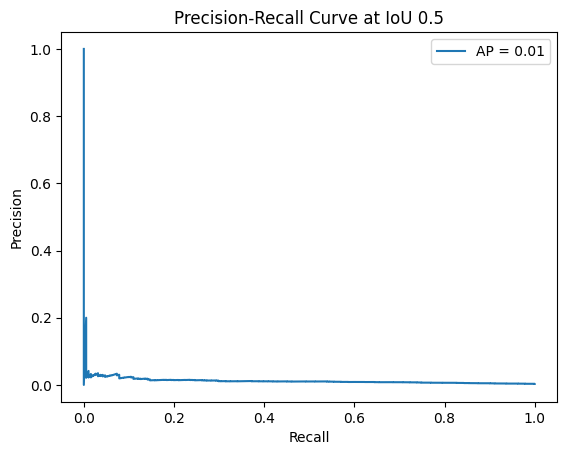

Total False Positives at IoU 0.5: 63949
Total False Negatives at IoU 0.5: 8699

--- Evaluation at IoU = 0.7 ---
Mean Average Precision (mAP) at IoU 0.7: 0.0002
Average Precision (AP) at IoU 0.7: 0.0016


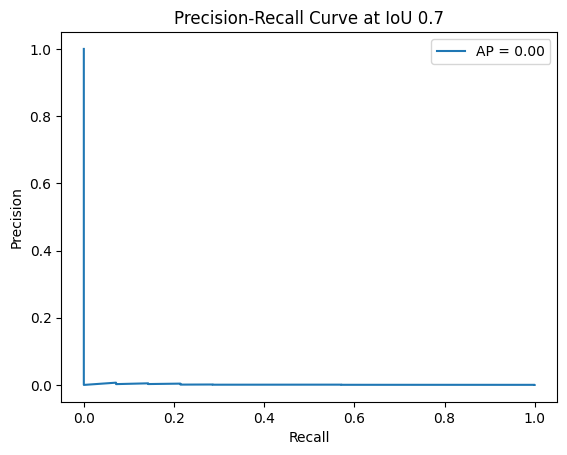

Total False Positives at IoU 0.7: 64126
Total False Negatives at IoU 0.7: 8876

--- Evaluation at IoU = 0.9 ---
Mean Average Precision (mAP) at IoU 0.9: 0.0000
Average Precision (AP) at IoU 0.9: -0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


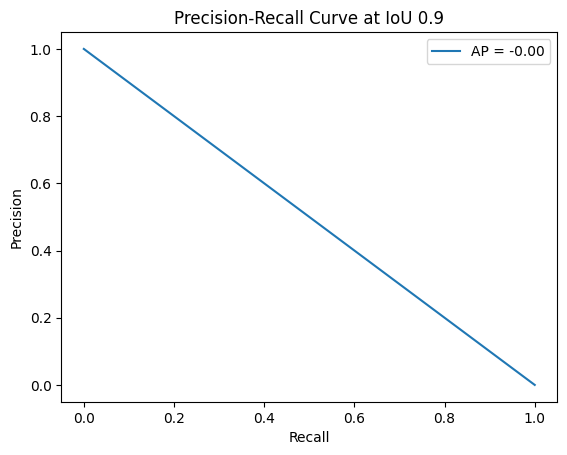

Total False Positives at IoU 0.9: 64140
Total False Negatives at IoU 0.9: 8890


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Define multiple IoU thresholds for evaluation
IOU_THRESHOLDS = [0.3, 0.5, 0.7, 0.9]

def evaluate_detections(predictions, ground_truths, iou_threshold):
    """
    Computes Precision-Recall metrics for a given IoU threshold.

    Args:
        predictions: List of predicted boxes and scores.
        ground_truths: List of ground-truth boxes.
        iou_threshold: IoU threshold for determining TP/FP.

    Returns:
        scores: List of prediction confidence scores.
        labels: Binary labels (1 for TP, 0 for FP).
    """
    all_scores = []
    all_labels = []
    
    for pred, gt in zip(predictions, ground_truths):
        pred_boxes = pred["boxes"].cpu().numpy() if len(pred["boxes"]) > 0 else np.array([])
        pred_scores = pred["scores"].cpu().numpy() if len(pred["scores"]) > 0 else np.array([])
        gt_boxes = gt["boxes"].cpu().numpy() if len(gt["boxes"]) > 0 else np.array([])

        gt_matched = [False] * len(gt_boxes)

        for i in range(len(pred_boxes)):
            score = pred_scores[i]
            pred_box = pred_boxes[i]
            match_found = False
            
            for j, gt_box in enumerate(gt_boxes):
                if gt_matched[j]:
                    continue  # Skip if already matched
                if iou(pred_box, gt_box) >= iou_threshold:
                    match_found = True
                    gt_matched[j] = True
                    break
            
            all_scores.append(score)
            all_labels.append(1 if match_found else 0)
    
    return np.array(all_scores), np.array(all_labels)


def count_fp_fn(predictions, ground_truths, iou_threshold):
    """
    Computes False Positives (FP) and False Negatives (FN) at a given IoU threshold.

    Args:
        predictions: List of predicted boxes.
        ground_truths: List of ground-truth boxes.
        iou_threshold: IoU threshold.

    Returns:
        total_fp: Total number of false positives.
        total_fn: Total number of false negatives.
    """
    total_fp = 0
    total_fn = 0
    
    for pred, gt in zip(predictions, ground_truths):
        pred_boxes = pred["boxes"].cpu().numpy() if len(pred["boxes"]) > 0 else np.array([])
        gt_boxes = gt["boxes"].cpu().numpy() if len(gt["boxes"]) > 0 else np.array([])
        gt_matched = [False] * len(gt_boxes)

        fp = 0
        for pred_box in pred_boxes:
            match_found = False
            for j, gt_box in enumerate(gt_boxes):
                if gt_matched[j]:
                    continue
                if iou(pred_box, gt_box) >= iou_threshold:
                    match_found = True
                    gt_matched[j] = True
                    break
            if not match_found:
                fp += 1

        fn = len(gt_boxes) - sum(gt_matched)
        total_fp += fp
        total_fn += fn
    
    return total_fp, total_fn


# Run evaluations at different IoU thresholds
val_preds, val_gts = validate(model, val_loader, device)

for iou_thresh in IOU_THRESHOLDS:
    print(f"\n--- Evaluation at IoU = {iou_thresh} ---")

    # Compute mAP
    map_score = compute_map(val_preds, val_gts, iou_threshold=iou_thresh)
    print(f"Mean Average Precision (mAP) at IoU {iou_thresh}: {map_score:.4f}")

    # Compute Precision-Recall and AP
    scores, labels = evaluate_detections(val_preds, val_gts, iou_threshold=iou_thresh)
    if len(scores) > 0 and len(labels) > 0:
        precision, recall, _ = precision_recall_curve(labels, scores)
        ap = average_precision_score(labels, scores)
        
        print(f"Average Precision (AP) at IoU {iou_thresh}: {ap:.4f}")

        # Plot Precision-Recall Curve
        plt.figure()
        plt.plot(recall, precision, label=f'AP = {ap:.2f}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve at IoU {iou_thresh}')
        plt.legend()
        plt.show()
    
    # Compute FP and FN
    total_fp, total_fn = count_fp_fn(val_preds, val_gts, iou_threshold=iou_thresh)
    print(f"Total False Positives at IoU {iou_thresh}: {total_fp}")
    print(f"Total False Negatives at IoU {iou_thresh}: {total_fn}")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


--- Epoch 0 ---


Validation: 100%|██████████| 17/17 [00:23<00:00,  1.39s/it]


Epoch [0] Train Loss: 1.0793 | Train mAP: 0.0034
Epoch [0] Validation mAP: 0.0034
--- Epoch 1 ---


Validation: 100%|██████████| 17/17 [00:23<00:00,  1.38s/it]


Epoch [1] Train Loss: 0.9589 | Train mAP: 0.0038
Epoch [1] Validation mAP: 0.0029
--- Epoch 2 ---


Validation: 100%|██████████| 17/17 [00:23<00:00,  1.40s/it]


Epoch [2] Train Loss: 0.9257 | Train mAP: 0.0037
Epoch [2] Validation mAP: 0.0038
--- Epoch 3 ---


Validation: 100%|██████████| 17/17 [00:23<00:00,  1.38s/it]


Epoch [3] Train Loss: 1.1017 | Train mAP: 0.0031
Epoch [3] Validation mAP: 0.0046
--- Epoch 4 ---


Validation: 100%|██████████| 17/17 [00:23<00:00,  1.36s/it]


Epoch [4] Train Loss: 0.9307 | Train mAP: 0.0038
Epoch [4] Validation mAP: 0.0030

--- Overall Evaluation at Various IoU Thresholds ---
mAP at IoU 0.3: 0.0161


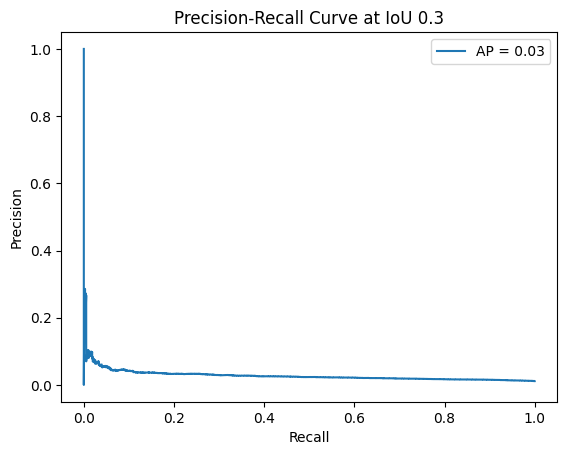

FP at IoU 0.3: 65152 | FN at IoU 0.3: 8134
mAP at IoU 0.5: 0.0030


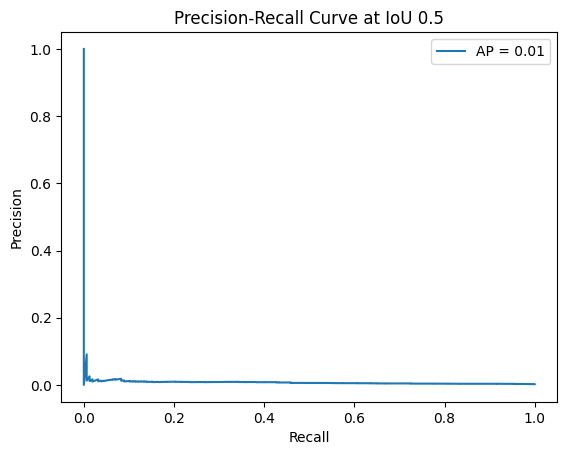

FP at IoU 0.5: 65751 | FN at IoU 0.5: 8733
mAP at IoU 0.7: 0.0002


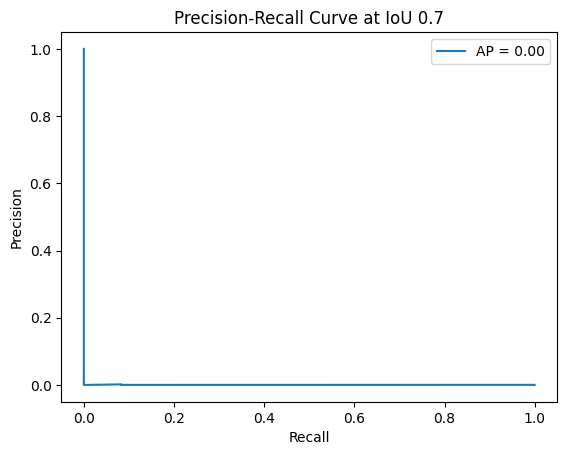

FP at IoU 0.7: 65896 | FN at IoU 0.7: 8878
mAP at IoU 0.9: 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


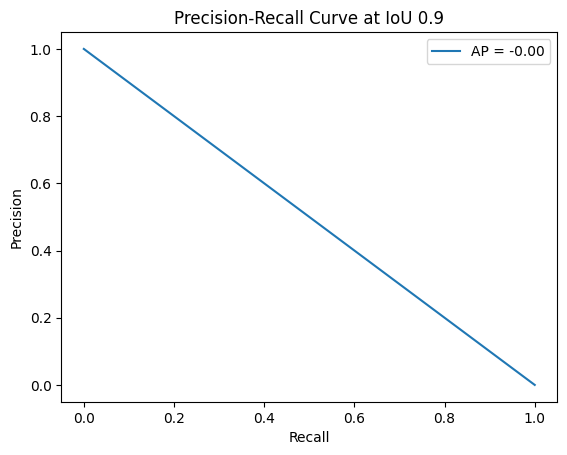

FP at IoU 0.9: 65908 | FN at IoU 0.9: 8890

--- Additional Detection Performance Analysis ---
Group 'occluded' has no images.

Group: non_occluded
  Number of images: 134
  mAP@0.5: 0.0030, AP: 0.0075
  Total FP: 65751, Total FN: 8733


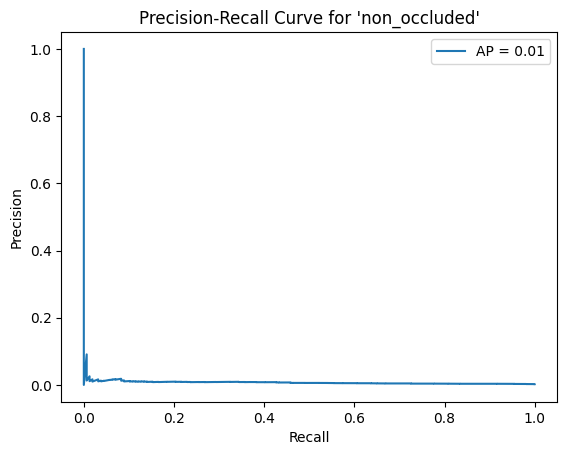


Group: clustered
  Number of images: 108
  mAP@0.5: 0.0038, AP: 0.0085
  Total FP: 53231, Total FN: 8730


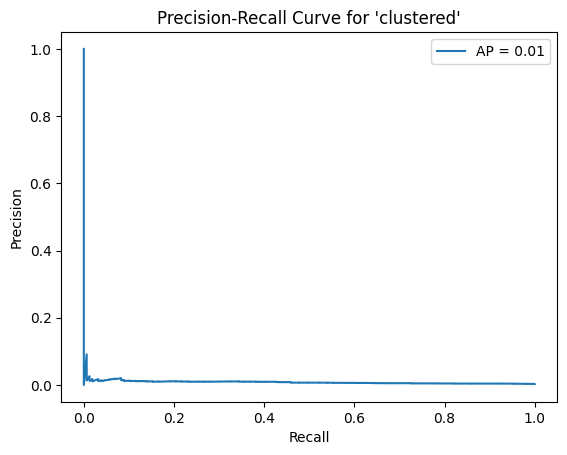


Group: isolated
  Number of images: 26
  mAP@0.5: 0.0000, AP: -0.0000
  Total FP: 12520, Total FN: 3


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


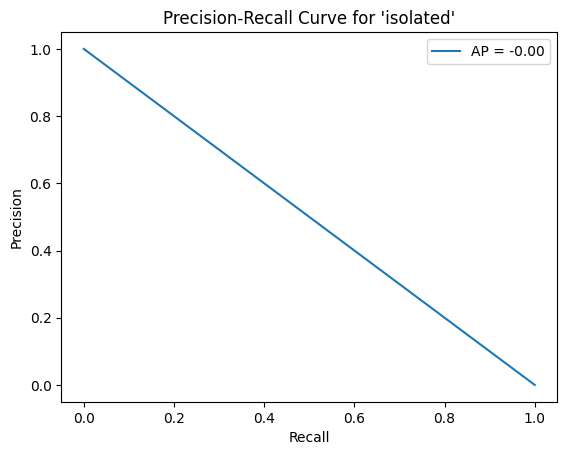


Group: small
  Number of images: 134
  mAP@0.5: 0.0030, AP: 0.0075
  Total FP: 65751, Total FN: 8733


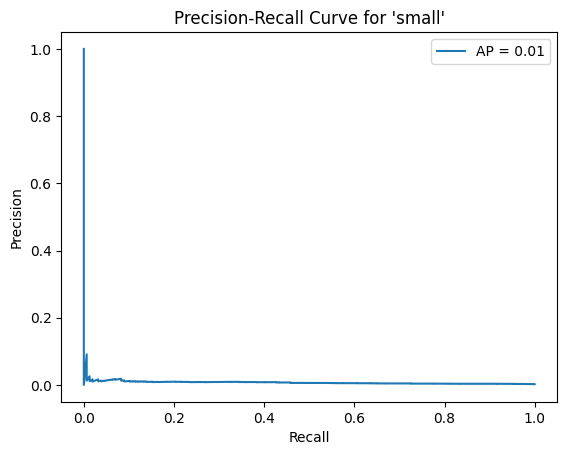

Group 'medium' has no images.
Group 'large' has no images.

Group: dark
  Number of images: 6
  mAP@0.5: 0.0071, AP: 0.0083
  Total FP: 2996, Total FN: 495


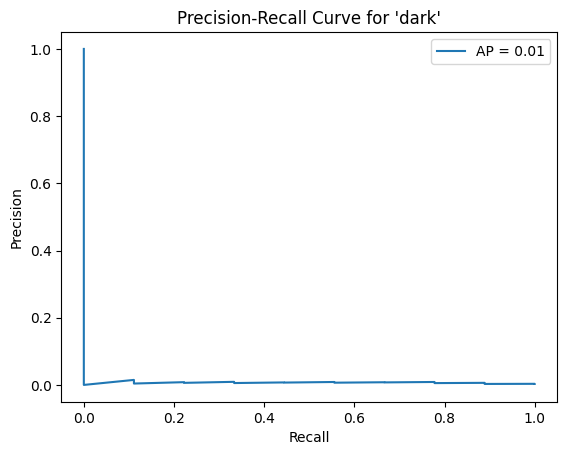


Group: bright
  Number of images: 128
  mAP@0.5: 0.0029, AP: 0.0078
  Total FP: 62755, Total FN: 8238


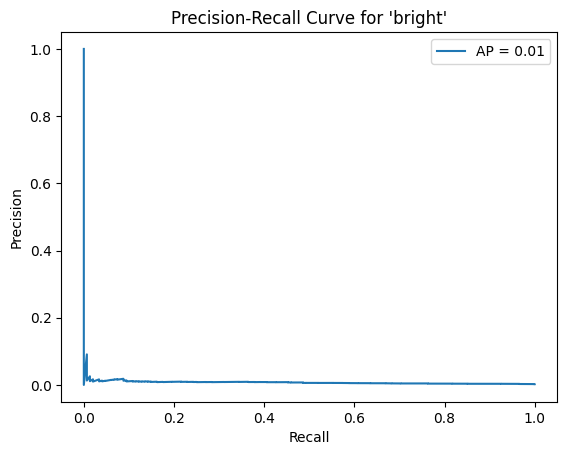

In [13]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.detection import FasterRCNN
from torchvision.models import resnet34
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import MultiScaleRoIAlign
from torchvision.transforms import ColorJitter, ToTensor
from PIL import Image, ImageOps
from tqdm import tqdm
from sklearn.metrics import precision_recall_curve, average_precision_score
import cv2
from skimage.morphology import remove_small_objects
from skimage.measure import regionprops
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage

# ---------------------------
# Evaluation Helper Functions
# ---------------------------
def iou(boxA, boxB):
    """Compute Intersection over Union (IoU) between two boxes in [x1,y1,x2,y2] format."""
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    if interArea == 0:
        return 0.0
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    return interArea / float(boxAArea + boxBArea - interArea)

def compute_map(predictions, ground_truths, iou_threshold=0.5):
    """Compute mean Average Precision (mAP) at a given IoU threshold."""
    all_ap = []
    for pred, gt in zip(predictions, ground_truths):
        pred_boxes = pred['boxes'].cpu().numpy() if len(pred['boxes']) > 0 else np.array([])
        pred_scores = pred['scores'].cpu().numpy() if 'scores' in pred and len(pred['scores']) > 0 else np.array([])
        gt_boxes = gt['boxes'].cpu().numpy() if len(gt['boxes']) > 0 else np.array([])
        if len(pred_boxes) == 0:
            all_ap.append(1.0 if len(gt_boxes)==0 else 0.0)
            continue
        sorted_indices = np.argsort(pred_scores)[::-1]
        pred_boxes = pred_boxes[sorted_indices]
        pred_scores = pred_scores[sorted_indices]

        tps, fps = [], []
        detected_gt = set()
        for pb in pred_boxes:
            match_found = False
            for j, gb in enumerate(gt_boxes):
                if j in detected_gt:
                    continue
                if iou(pb, gb) >= iou_threshold:
                    tps.append(1)
                    fps.append(0)
                    detected_gt.add(j)
                    match_found = True
                    break
            if not match_found:
                tps.append(0)
                fps.append(1)
        tps = np.cumsum(tps)
        fps = np.cumsum(fps)
        precision = tps / (tps + fps + 1e-6)
        recall = tps / (len(gt_boxes) + 1e-6)
        recall_points = np.linspace(0, 1, 101)
        precision_at_recall = np.interp(recall_points, recall, precision)
        ap = np.trapz(precision_at_recall, recall_points)
        all_ap.append(ap)
    return np.mean(all_ap) if len(all_ap) > 0 else 0.0

def evaluate_detections(predictions, ground_truths, iou_threshold):
    """Returns lists of scores and binary labels (TP=1, FP=0) for PR computations."""
    all_scores, all_labels = [], []
    for pred, gt in zip(predictions, ground_truths):
        pred_boxes = pred["boxes"].cpu().numpy() if len(pred["boxes"]) > 0 else np.array([])
        pred_scores = pred["scores"].cpu().numpy() if "scores" in pred and len(pred["scores"]) > 0 else np.array([])
        gt_boxes = gt["boxes"].cpu().numpy() if len(gt["boxes"]) > 0 else np.array([])
        gt_matched = [False] * len(gt_boxes)
        for i in range(len(pred_boxes)):
            score = pred_scores[i]
            pb = pred_boxes[i]
            match_found = False
            for j, gb in enumerate(gt_boxes):
                if gt_matched[j]:
                    continue
                if iou(pb, gb) >= iou_threshold:
                    match_found = True
                    gt_matched[j] = True
                    break
            all_scores.append(score)
            all_labels.append(1 if match_found else 0)
    return np.array(all_scores), np.array(all_labels)

def count_fp_fn(predictions, ground_truths, iou_threshold):
    """Computes total false positives (FP) and false negatives (FN) at a given IoU threshold."""
    total_fp, total_fn = 0, 0
    for pred, gt in zip(predictions, ground_truths):
        pred_boxes = pred["boxes"].cpu().numpy() if len(pred["boxes"]) > 0 else np.array([])
        gt_boxes = gt["boxes"].cpu().numpy() if len(gt["boxes"]) > 0 else np.array([])
        gt_matched = [False] * len(gt_boxes)
        fp = 0
        for pb in pred_boxes:
            match_found = False
            for j, gb in enumerate(gt_boxes):
                if gt_matched[j]:
                    continue
                if iou(pb, gb) >= iou_threshold:
                    match_found = True
                    gt_matched[j] = True
                    break
            if not match_found:
                fp += 1
        fn = len(gt_boxes) - sum(gt_matched)
        total_fp += fp
        total_fn += fn
    return total_fp, total_fn

# ---------------------------
# Dataset, Model, and Training Setup
# ---------------------------
class FruitDetectionDataset(Dataset):
    def __init__(self, image_dir, mask_dir, file_list=None, transform=None, augment=False):
        """
        Args:
            image_dir (str): Directory containing images.
            mask_dir (str): Directory containing corresponding masks.
            file_list (list, optional): Filenames to use. If None, uses all images.
            transform (callable, optional): Transformation for images.
            augment (bool): If True, apply data augmentation.
        """
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_files = file_list if file_list is not None else sorted(os.listdir(image_dir))
        self.augment = augment
        self.transform = transform
        self.color_jitter = ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1) if self.augment else None

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        filename = self.image_files[idx]
        image_path = os.path.join(self.image_dir, filename)
        mask_path = os.path.join(self.mask_dir, filename)
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        if self.augment:
            image, mask = self.apply_geometric_transforms(image, mask)
            image = self.color_jitter(image)
        image = self.transform(image) if self.transform else ToTensor()(image)
        # Use your previously defined masks_to_boxes function on mask_path
        boxes = masks_to_boxes(mask_path)
        # Convert boxes from (x, y, w, h) to (x1, y1, x2, y2)
        boxes_converted = [[x, y, x + w, y + h] for (x, y, w, h) in boxes]
        if len(boxes_converted) == 0:
            boxes_tensor = torch.zeros((0, 4), dtype=torch.float32)
            labels_tensor = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes_tensor = torch.as_tensor(boxes_converted, dtype=torch.float32)
            labels_tensor = torch.ones((boxes_tensor.shape[0],), dtype=torch.int64)
        target = {"boxes": boxes_tensor, "labels": labels_tensor, "image_id": torch.tensor([idx])}
        return image, target

    def apply_geometric_transforms(self, image, mask):
        if random.random() < 0.5:
            image = ImageOps.mirror(image)
            mask = ImageOps.mirror(mask)
        if random.random() < 0.5:
            image = ImageOps.flip(image)
            mask = ImageOps.flip(mask)
        angle = random.choice([0, 90, 180, 270])
        if angle != 0:
            image = image.rotate(angle, expand=True)
            mask = mask.rotate(angle, expand=True)
        return image, mask

# Use your provided masks_to_boxes (and its helper apply_nms) functions here.
# (They are assumed to be defined above.)

def get_faster_rcnn_resnet34(num_classes):
    """
    Constructs a Faster R-CNN model using a ResNet-34 backbone.
    """
    resnet = resnet34(pretrained=True)
    backbone = nn.Sequential(*list(resnet.children())[:-2])
    backbone.out_channels = 512
    anchor_generator = AnchorGenerator(sizes=((32, 64, 128),), aspect_ratios=((0.8, 1.0, 1.25),))
    roi_pooler = MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)
    model = FasterRCNN(backbone, num_classes=num_classes,
                       rpn_anchor_generator=anchor_generator,
                       box_roi_pool=roi_pooler,
                       box_detections_per_img=1000)
    return model

def collate_fn(batch):
    return tuple(zip(*batch))

def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10):
    model.train()
    total_loss = 0.0
    pbar = tqdm(enumerate(data_loader), total=len(data_loader), desc=f"Epoch {epoch} Training")
    for i, (images, targets) in pbar:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        total_loss += losses.item()
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        if i % print_freq == 0:
            pbar.set_postfix(loss=f"{losses.item():.4f}")
    return total_loss / len(data_loader)

@torch.no_grad()
def validate(model, data_loader, device):
    model.eval()
    all_preds, all_gts = [], []
    for images, targets in tqdm(data_loader, total=len(data_loader), desc="Validation"):
        images = [img.to(device) for img in images]
        preds = model(images)
        all_preds.extend(preds)
        all_gts.extend(targets)
    return all_preds, all_gts

# ---------------------------
# Training and Evaluation
# ---------------------------
IOU_THRESHOLD = 0.5
TRAIN_DATASET_IMAGE_PATH = r'/kaggle/input/cv-a3q2/Q2/detection/train/images'
TRAIN_DATASET_MASK_PATH = r'/kaggle/input/cv-a3q2/Q2/detection/train/masks'
all_files = sorted(os.listdir(TRAIN_DATASET_IMAGE_PATH))
split_ratio = 0.8
num_train = int(len(all_files) * split_ratio)
train_files = all_files[:num_train]
val_files   = all_files[num_train:]
# Using a basic transform (convert to tensor)
transform = transforms.Compose([ToTensor()])
train_dataset = FruitDetectionDataset(TRAIN_DATASET_IMAGE_PATH, TRAIN_DATASET_MASK_PATH, file_list=train_files, transform=transform, augment=True)
val_dataset   = FruitDetectionDataset(TRAIN_DATASET_IMAGE_PATH, TRAIN_DATASET_MASK_PATH, file_list=val_files, transform=transform, augment=False)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2  
model = get_faster_rcnn_resnet34(num_classes).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 5

for epoch in range(num_epochs):
    print(f"--- Epoch {epoch} ---")
    train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
    train_preds, train_gts = validate(model, train_loader, device)
    train_map = compute_map(train_preds, train_gts, iou_threshold=IOU_THRESHOLD)
    val_preds, val_gts = validate(model, val_loader, device)
    val_map = compute_map(val_preds, val_gts, iou_threshold=IOU_THRESHOLD)
    print(f"Epoch [{epoch}] Train Loss: {train_loss:.4f} | Train mAP: {train_map:.4f}")
    print(f"Epoch [{epoch}] Validation mAP: {val_map:.4f}")

# Also evaluate at different IoU thresholds and plot PR curves
IOU_THRESHOLDS = [0.3, 0.5, 0.7, 0.9]
print("\n--- Overall Evaluation at Various IoU Thresholds ---")
for iou_thr in IOU_THRESHOLDS:
    map_score = compute_map(val_preds, val_gts, iou_threshold=iou_thr)
    print(f"mAP at IoU {iou_thr}: {map_score:.4f}")
    scores, labels = evaluate_detections(val_preds, val_gts, iou_threshold=iou_thr)
    if len(scores) > 0 and len(labels) > 0:
        precision, recall, _ = precision_recall_curve(labels, scores)
        ap = average_precision_score(labels, scores)
        plt.figure()
        plt.plot(recall, precision, label=f'AP = {ap:.2f}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve at IoU {iou_thr}')
        plt.legend()
        plt.show()
    fp, fn = count_fp_fn(val_preds, val_gts, iou_threshold=iou_thr)
    print(f"FP at IoU {iou_thr}: {fp} | FN at IoU {iou_thr}: {fn}")

# ---------------------------
# Additional Analysis Function
# ---------------------------
def analyze_detection_performance(val_files, val_preds, val_gts, image_dir):
    """
    Analyze detection performance by grouping validation images according to:
      - Occlusion (average pairwise IoU among ground truth boxes)
      - Density (number of fruits per image)
      - Scale (average fruit area relative to image area)
      - Brightness (average brightness in V channel)
    For each group, compute mAP, AP, FP, FN and plot the PR curve.
    """
    # Thresholds (adjust these based on your dataset)
    occlusion_threshold = 0.3      # average IoU above which consider image as occluded
    density_threshold = 3          # images with >= 3 fruits are considered clustered
    scale_thresholds = (0.01, 0.05)  # relative area thresholds for small, medium, large fruits
    brightness_threshold = 100     # average brightness threshold (0-255)
    
    # Initialize grouping dictionaries. Each group will hold indices of images.
    groups = {
         "occluded": [],
         "non_occluded": [],
         "clustered": [],
         "isolated": [],
         "small": [],
         "medium": [],
         "large": [],
         "dark": [],
         "bright": []
    }
    
    for idx, file in enumerate(val_files):
         image_path = os.path.join(image_dir, file)
         image = cv2.imread(image_path)
         if image is None:
              continue
         height, width = image.shape[:2]
         # Get ground truth boxes (assumed in [x1,y1,x2,y2] format)
         gt = val_gts[idx]
         gt_boxes = gt["boxes"].cpu().numpy() if len(gt["boxes"]) > 0 else np.array([])
         
         # Occlusion: compute average pairwise IoU among gt boxes (if more than one box)
         avg_iou = 0.0
         if len(gt_boxes) > 1:
              ious = []
              for i in range(len(gt_boxes)):
                   for j in range(i+1, len(gt_boxes)):
                         ious.append(iou(gt_boxes[i], gt_boxes[j]))
              avg_iou = np.mean(ious) if ious else 0.0
         if avg_iou >= occlusion_threshold:
              groups["occluded"].append(idx)
         else:
              groups["non_occluded"].append(idx)
         # Density: if number of fruits >= density_threshold
         if len(gt_boxes) >= density_threshold:
              groups["clustered"].append(idx)
         else:
              groups["isolated"].append(idx)
         # Scale: compute average relative area of fruits (area / image area)
         avg_rel_area = 0.0
         if len(gt_boxes) > 0:
              areas = []
              for box in gt_boxes:
                   area = (box[2]-box[0])*(box[3]-box[1])
                   rel_area = area / (width * height)
                   areas.append(rel_area)
              avg_rel_area = np.mean(areas)
         if avg_rel_area < scale_thresholds[0]:
              groups["small"].append(idx)
         elif avg_rel_area < scale_thresholds[1]:
              groups["medium"].append(idx)
         else:
              groups["large"].append(idx)
         # Brightness: compute average brightness from V channel
         hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
         avg_brightness = np.mean(hsv[:,:,2])
         if avg_brightness < brightness_threshold:
              groups["dark"].append(idx)
         else:
              groups["bright"].append(idx)
    
    # For each group, compute evaluation metrics and plot PR curve
    for group_name, indices in groups.items():
         if len(indices) == 0:
              print(f"Group '{group_name}' has no images.")
              continue
         group_preds = [val_preds[i] for i in indices]
         group_gts = [val_gts[i] for i in indices]
         group_map = compute_map(group_preds, group_gts, iou_threshold=0.5)
         scores, labels = evaluate_detections(group_preds, group_gts, iou_threshold=0.5)
         group_ap = average_precision_score(labels, scores) if len(scores) > 0 else 0.0
         fp, fn = count_fp_fn(group_preds, group_gts, iou_threshold=0.5)
         print(f"\nGroup: {group_name}")
         print(f"  Number of images: {len(indices)}")
         print(f"  mAP@0.5: {group_map:.4f}, AP: {group_ap:.4f}")
         print(f"  Total FP: {fp}, Total FN: {fn}")
         if len(scores) > 0:
              precision, recall, _ = precision_recall_curve(labels, scores)
              plt.figure()
              plt.plot(recall, precision, label=f'AP = {group_ap:.2f}')
              plt.xlabel("Recall")
              plt.ylabel("Precision")
              plt.title(f"Precision-Recall Curve for '{group_name}'")
              plt.legend()
              plt.show()

# ---------------------------
# Run Additional Analysis
# ---------------------------
# We assume that 'val_files' (a list of filenames in the validation set) is available.
# Here, we use the same TRAIN_DATASET_IMAGE_PATH as the source for images.
print("\n--- Additional Detection Performance Analysis ---")
analyze_detection_performance(val_files, val_preds, val_gts, TRAIN_DATASET_IMAGE_PATH)


Hyperparameter



[Experiment] Aug=NoAug, Res=None, Epoch=1/5


Validation: 100%|██████████| 34/34 [00:23<00:00,  1.47it/s]


   -> Train Loss=0.9200, Val mAP@0.5=0.0279

[Experiment] Aug=NoAug, Res=None, Epoch=2/5


Validation: 100%|██████████| 34/34 [00:22<00:00,  1.48it/s]


   -> Train Loss=0.8023, Val mAP@0.5=0.0417

[Experiment] Aug=NoAug, Res=None, Epoch=3/5


Validation: 100%|██████████| 34/34 [00:22<00:00,  1.49it/s]


   -> Train Loss=0.7795, Val mAP@0.5=0.0461

[Experiment] Aug=NoAug, Res=None, Epoch=4/5


Validation: 100%|██████████| 34/34 [00:23<00:00,  1.44it/s]


   -> Train Loss=0.7573, Val mAP@0.5=0.0480

[Experiment] Aug=NoAug, Res=None, Epoch=5/5


Validation: 100%|██████████| 34/34 [00:22<00:00,  1.48it/s]


   -> Train Loss=0.7441, Val mAP@0.5=0.0483


Validation: 100%|██████████| 34/34 [00:22<00:00,  1.49it/s]


   [Val@conf=0.3] mAP_0.5=0.0531, AP=0.0981, FP=17076, FN=7916
   [Val@conf=0.5] mAP_0.5=0.0681, AP=0.1125, FP=8256, FN=8218
   [Val@conf=0.7] mAP_0.5=0.1985, AP=0.1852, FP=379, FN=8811

Plotting Precision-Recall Curves for different IoU thresholds:


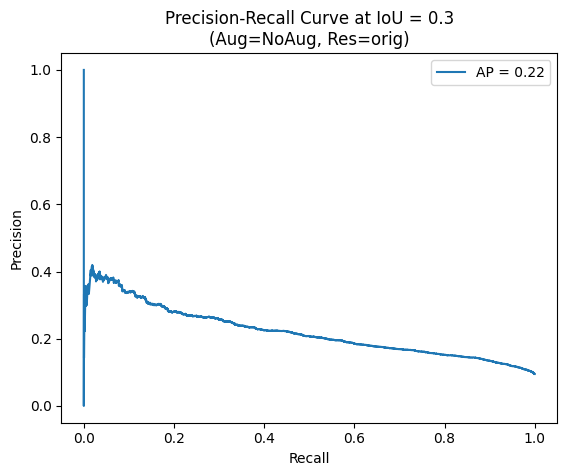

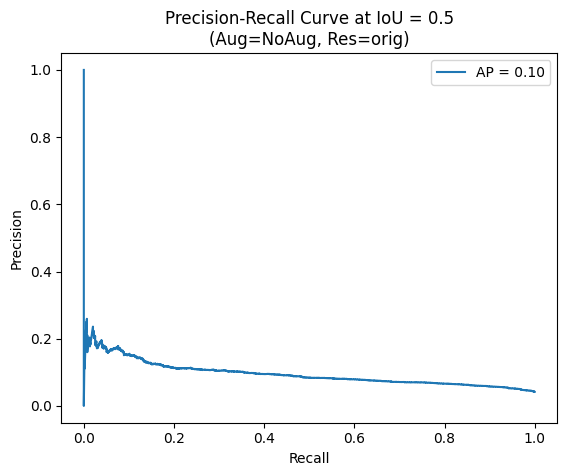

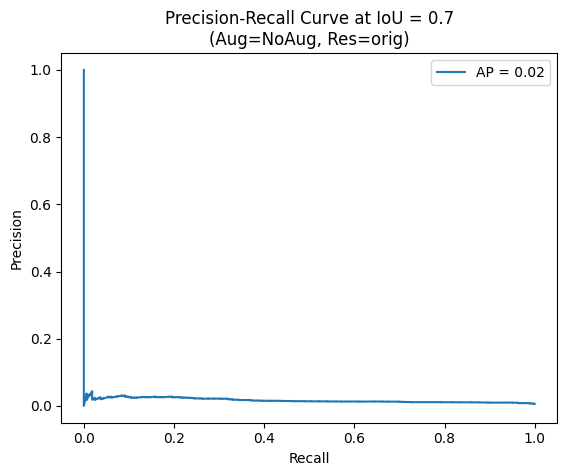

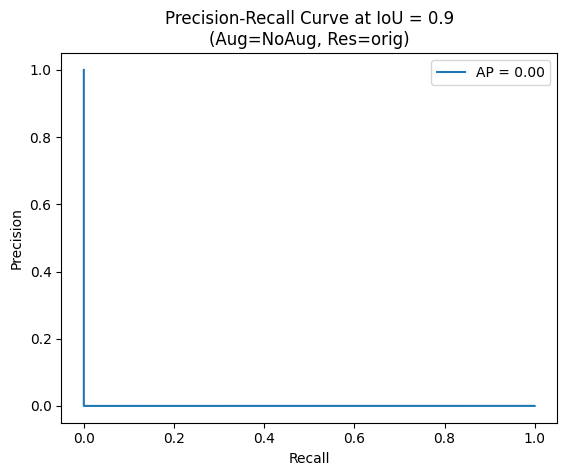

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



[Experiment] Aug=NoAug, Res=(300, 300), Epoch=1/5


Validation: 100%|██████████| 34/34 [00:11<00:00,  3.09it/s]


   -> Train Loss=0.8665, Val mAP@0.5=0.0225

[Experiment] Aug=NoAug, Res=(300, 300), Epoch=2/5


Validation: 100%|██████████| 34/34 [00:10<00:00,  3.11it/s]


   -> Train Loss=0.7283, Val mAP@0.5=0.0308

[Experiment] Aug=NoAug, Res=(300, 300), Epoch=3/5


Validation: 100%|██████████| 34/34 [00:10<00:00,  3.12it/s]


   -> Train Loss=0.6884, Val mAP@0.5=0.0298

[Experiment] Aug=NoAug, Res=(300, 300), Epoch=4/5


Validation: 100%|██████████| 34/34 [00:11<00:00,  3.07it/s]


   -> Train Loss=0.6650, Val mAP@0.5=0.0353

[Experiment] Aug=NoAug, Res=(300, 300), Epoch=5/5


Validation: 100%|██████████| 34/34 [00:10<00:00,  3.10it/s]


   -> Train Loss=0.6511, Val mAP@0.5=0.0378


Validation: 100%|██████████| 34/34 [00:10<00:00,  3.16it/s]


   [Val@conf=0.3] mAP_0.5=0.0475, AP=0.0982, FP=11492, FN=5969
   [Val@conf=0.5] mAP_0.5=0.0647, AP=0.1121, FP=4877, FN=6154
   [Val@conf=0.7] mAP_0.5=0.1499, AP=0.1495, FP=405, FN=6529

Plotting Precision-Recall Curves for different IoU thresholds:


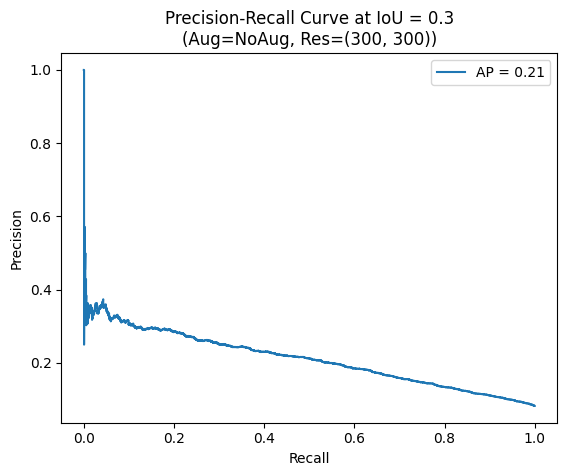

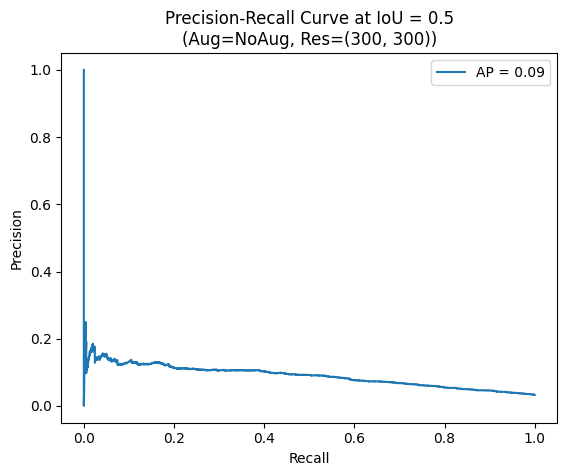

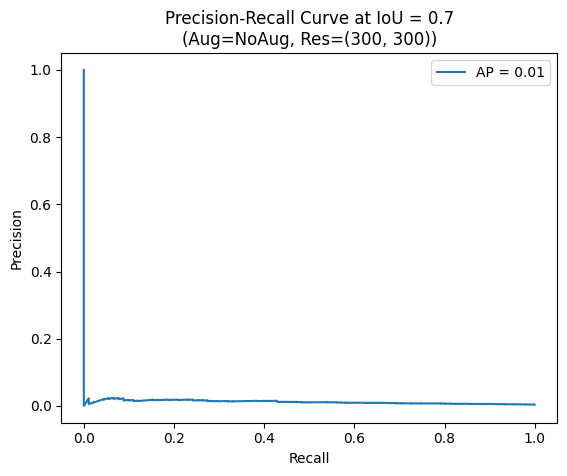

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


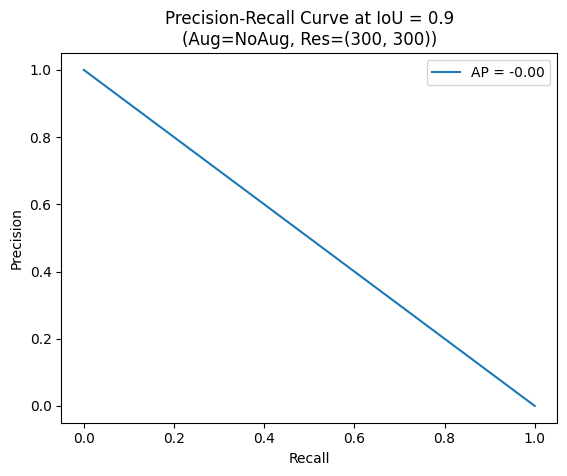

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



[Experiment] Aug=NoAug, Res=(512, 512), Epoch=1/5


Validation: 100%|██████████| 34/34 [00:14<00:00,  2.31it/s]


   -> Train Loss=0.9014, Val mAP@0.5=0.0186

[Experiment] Aug=NoAug, Res=(512, 512), Epoch=2/5


Validation: 100%|██████████| 34/34 [00:14<00:00,  2.32it/s]


   -> Train Loss=0.7240, Val mAP@0.5=0.0272

[Experiment] Aug=NoAug, Res=(512, 512), Epoch=3/5


Validation: 100%|██████████| 34/34 [00:14<00:00,  2.30it/s]


   -> Train Loss=0.6851, Val mAP@0.5=0.0295

[Experiment] Aug=NoAug, Res=(512, 512), Epoch=4/5


Validation: 100%|██████████| 34/34 [00:14<00:00,  2.33it/s]


   -> Train Loss=0.6626, Val mAP@0.5=0.0332

[Experiment] Aug=NoAug, Res=(512, 512), Epoch=5/5


Validation: 100%|██████████| 34/34 [00:14<00:00,  2.30it/s]


   -> Train Loss=0.6426, Val mAP@0.5=0.0338


Validation: 100%|██████████| 34/34 [00:14<00:00,  2.34it/s]


   [Val@conf=0.3] mAP_0.5=0.0375, AP=0.0726, FP=16801, FN=7825
   [Val@conf=0.5] mAP_0.5=0.0453, AP=0.0825, FP=8681, FN=8026
   [Val@conf=0.7] mAP_0.5=0.1208, AP=0.1190, FP=548, FN=8463

Plotting Precision-Recall Curves for different IoU thresholds:


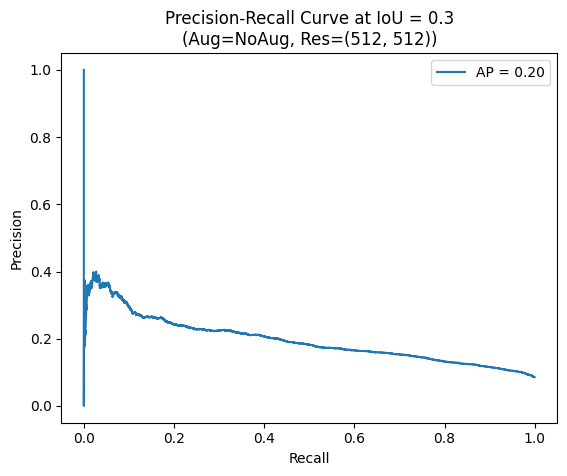

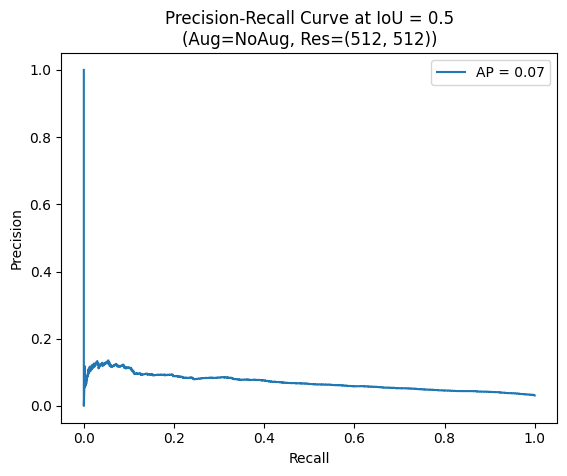

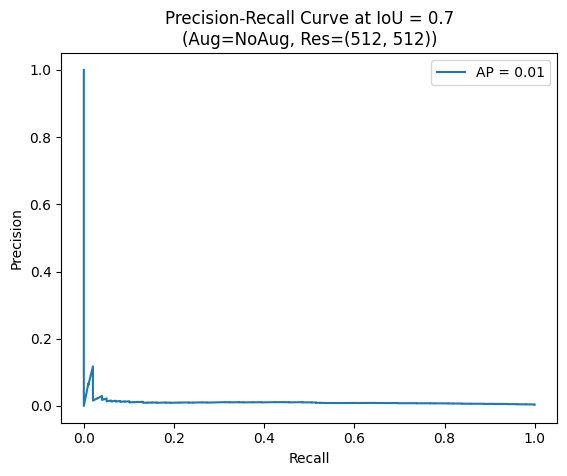

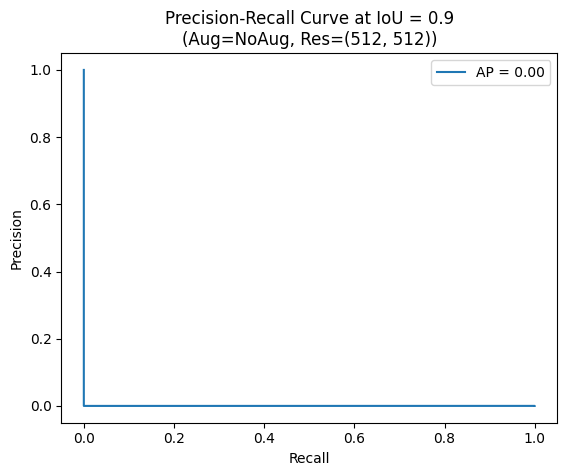

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



[Experiment] Aug=FlipRotate, Res=None, Epoch=1/5


Validation: 100%|██████████| 34/34 [00:23<00:00,  1.47it/s]


   -> Train Loss=0.8951, Val mAP@0.5=0.0315

[Experiment] Aug=FlipRotate, Res=None, Epoch=2/5


Validation: 100%|██████████| 34/34 [00:22<00:00,  1.50it/s]


   -> Train Loss=0.8127, Val mAP@0.5=0.0429

[Experiment] Aug=FlipRotate, Res=None, Epoch=3/5


Validation: 100%|██████████| 34/34 [00:22<00:00,  1.49it/s]


   -> Train Loss=0.8070, Val mAP@0.5=0.0499

[Experiment] Aug=FlipRotate, Res=None, Epoch=4/5


Validation: 100%|██████████| 34/34 [00:22<00:00,  1.49it/s]


   -> Train Loss=0.7909, Val mAP@0.5=0.0596

[Experiment] Aug=FlipRotate, Res=None, Epoch=5/5


Validation: 100%|██████████| 34/34 [00:22<00:00,  1.52it/s]


   -> Train Loss=0.7924, Val mAP@0.5=0.0633


Validation: 100%|██████████| 34/34 [00:22<00:00,  1.53it/s]


   [Val@conf=0.3] mAP_0.5=0.0661, AP=0.1681, FP=19609, FN=7676
   [Val@conf=0.5] mAP_0.5=0.0801, AP=0.1861, FP=10801, FN=7869
   [Val@conf=0.7] mAP_0.5=0.3192, AP=0.3604, FP=348, FN=8740

Plotting Precision-Recall Curves for different IoU thresholds:


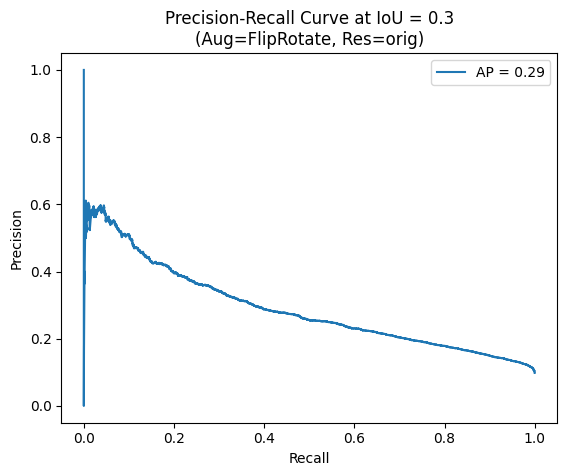

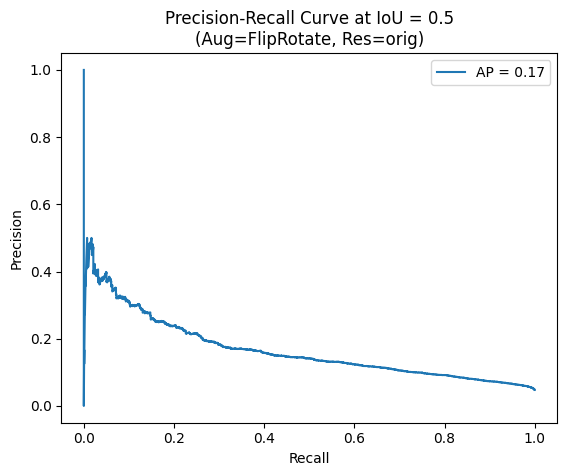

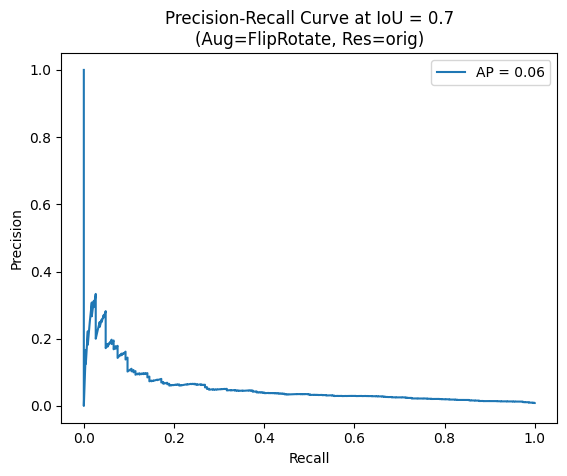

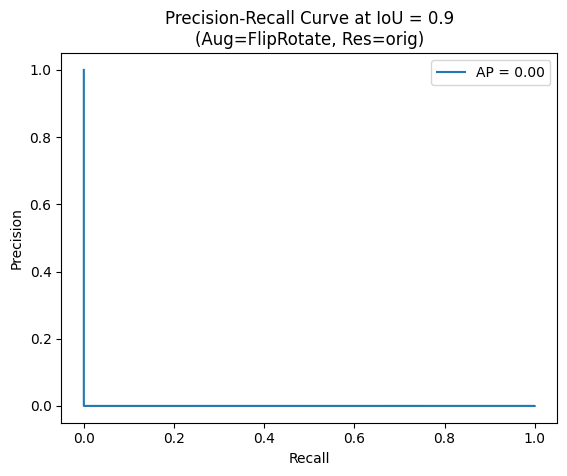

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



[Experiment] Aug=FlipRotate, Res=(300, 300), Epoch=1/5


Validation: 100%|██████████| 34/34 [00:11<00:00,  3.05it/s]


   -> Train Loss=0.8926, Val mAP@0.5=0.0187

[Experiment] Aug=FlipRotate, Res=(300, 300), Epoch=2/5


Validation: 100%|██████████| 34/34 [00:11<00:00,  3.05it/s]


   -> Train Loss=0.7553, Val mAP@0.5=0.0243

[Experiment] Aug=FlipRotate, Res=(300, 300), Epoch=3/5


Validation: 100%|██████████| 34/34 [00:10<00:00,  3.11it/s]


   -> Train Loss=0.7385, Val mAP@0.5=0.0318

[Experiment] Aug=FlipRotate, Res=(300, 300), Epoch=4/5


Validation: 100%|██████████| 34/34 [00:10<00:00,  3.11it/s]


   -> Train Loss=0.7197, Val mAP@0.5=0.0369

[Experiment] Aug=FlipRotate, Res=(300, 300), Epoch=5/5


Validation: 100%|██████████| 34/34 [00:11<00:00,  3.06it/s]


   -> Train Loss=0.7124, Val mAP@0.5=0.0395


Validation: 100%|██████████| 34/34 [00:10<00:00,  3.24it/s]


   [Val@conf=0.3] mAP_0.5=0.0446, AP=0.0908, FP=16361, FN=5801
   [Val@conf=0.5] mAP_0.5=0.0563, AP=0.1033, FP=7815, FN=6014
   [Val@conf=0.7] mAP_0.5=0.2157, AP=0.1418, FP=93, FN=6570

Plotting Precision-Recall Curves for different IoU thresholds:


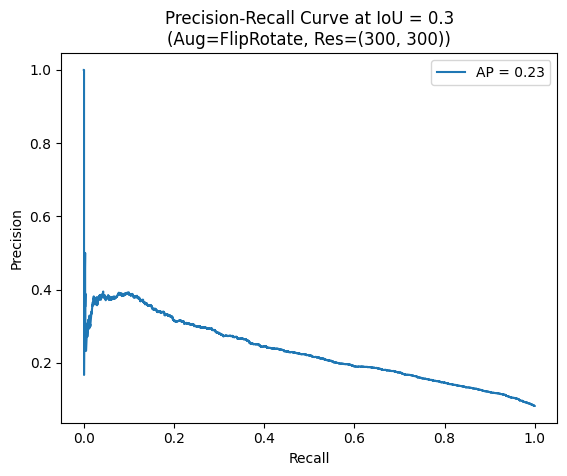

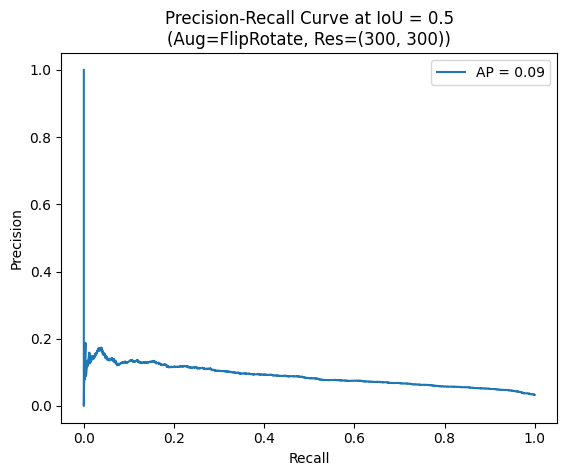

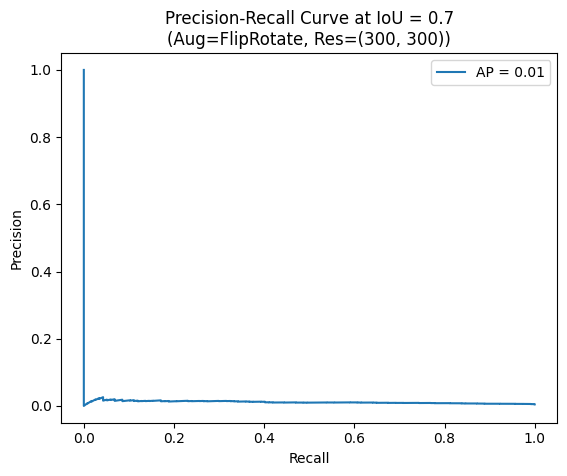

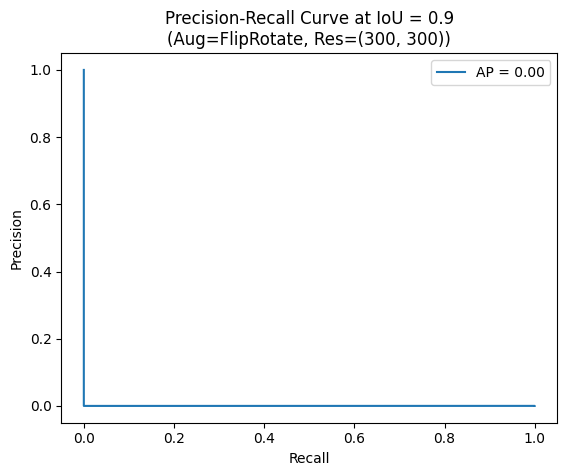

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



[Experiment] Aug=FlipRotate, Res=(512, 512), Epoch=1/5


Validation: 100%|██████████| 34/34 [00:14<00:00,  2.33it/s]


   -> Train Loss=0.9095, Val mAP@0.5=0.0207

[Experiment] Aug=FlipRotate, Res=(512, 512), Epoch=2/5


Validation: 100%|██████████| 34/34 [00:14<00:00,  2.31it/s]


   -> Train Loss=0.7646, Val mAP@0.5=0.0270

[Experiment] Aug=FlipRotate, Res=(512, 512), Epoch=3/5


Validation: 100%|██████████| 34/34 [00:14<00:00,  2.32it/s]


   -> Train Loss=0.7404, Val mAP@0.5=0.0298

[Experiment] Aug=FlipRotate, Res=(512, 512), Epoch=4/5


Validation: 100%|██████████| 34/34 [00:14<00:00,  2.34it/s]


   -> Train Loss=0.7166, Val mAP@0.5=0.0303

[Experiment] Aug=FlipRotate, Res=(512, 512), Epoch=5/5


Validation: 100%|██████████| 34/34 [00:14<00:00,  2.35it/s]


   -> Train Loss=0.7090, Val mAP@0.5=0.0345


Validation: 100%|██████████| 34/34 [00:14<00:00,  2.37it/s]


   [Val@conf=0.3] mAP_0.5=0.0370, AP=0.0701, FP=17661, FN=7821
   [Val@conf=0.5] mAP_0.5=0.0439, AP=0.0808, FP=8682, FN=8043
   [Val@conf=0.7] mAP_0.5=0.1890, AP=0.3108, FP=87, FN=8524

Plotting Precision-Recall Curves for different IoU thresholds:


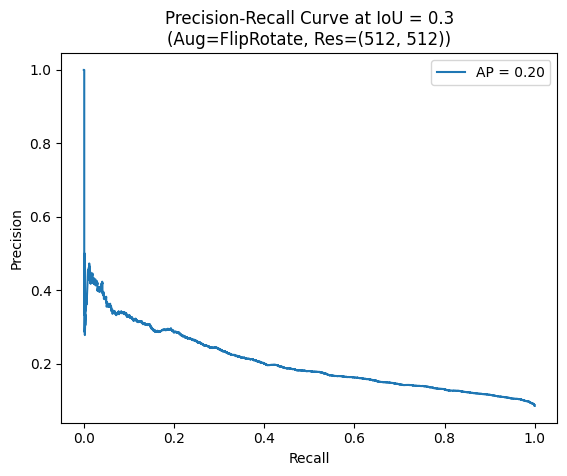

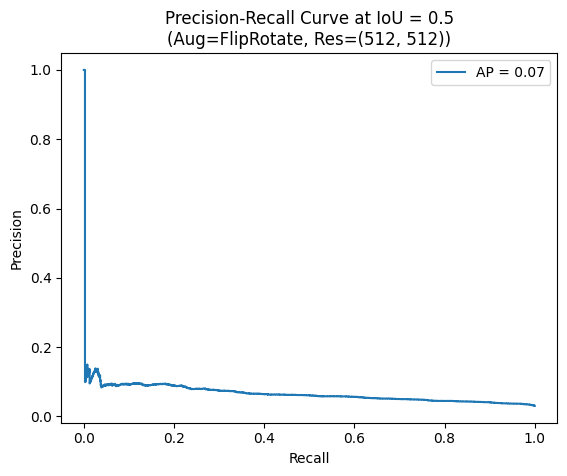

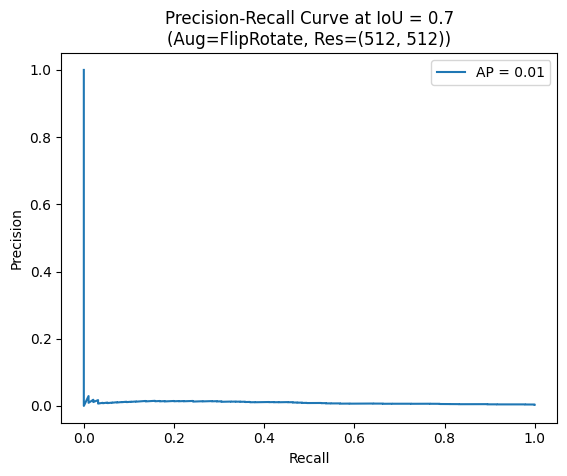

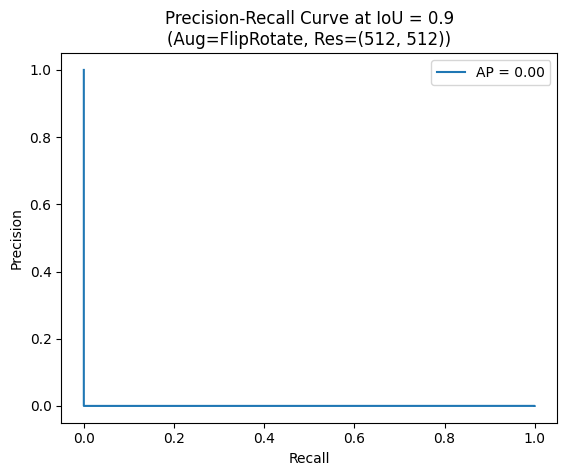

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



[Experiment] Aug=FlipRotate+Color, Res=None, Epoch=1/5


Validation: 100%|██████████| 34/34 [00:22<00:00,  1.48it/s]


   -> Train Loss=0.9293, Val mAP@0.5=0.0262

[Experiment] Aug=FlipRotate+Color, Res=None, Epoch=2/5


Validation: 100%|██████████| 34/34 [00:22<00:00,  1.51it/s]


   -> Train Loss=0.8315, Val mAP@0.5=0.0403

[Experiment] Aug=FlipRotate+Color, Res=None, Epoch=3/5


Validation: 100%|██████████| 34/34 [00:22<00:00,  1.51it/s]


   -> Train Loss=0.8231, Val mAP@0.5=0.0517

[Experiment] Aug=FlipRotate+Color, Res=None, Epoch=4/5


Validation: 100%|██████████| 34/34 [00:22<00:00,  1.51it/s]


   -> Train Loss=0.8060, Val mAP@0.5=0.0530

[Experiment] Aug=FlipRotate+Color, Res=None, Epoch=5/5


Validation: 100%|██████████| 34/34 [00:22<00:00,  1.53it/s]


   -> Train Loss=0.8002, Val mAP@0.5=0.0623


Validation: 100%|██████████| 34/34 [00:22<00:00,  1.54it/s]


   [Val@conf=0.3] mAP_0.5=0.0642, AP=0.1559, FP=19885, FN=7710
   [Val@conf=0.5] mAP_0.5=0.0798, AP=0.1842, FP=9255, FN=8009
   [Val@conf=0.7] mAP_0.5=0.2472, AP=0.4248, FP=299, FN=8776

Plotting Precision-Recall Curves for different IoU thresholds:


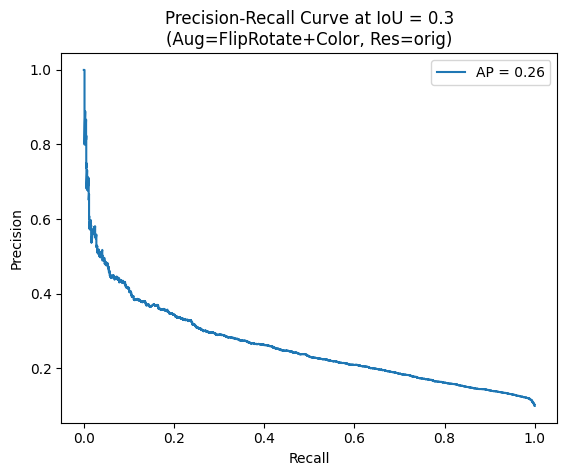

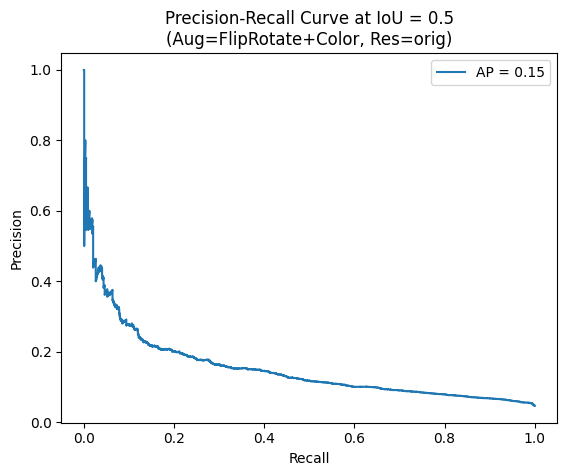

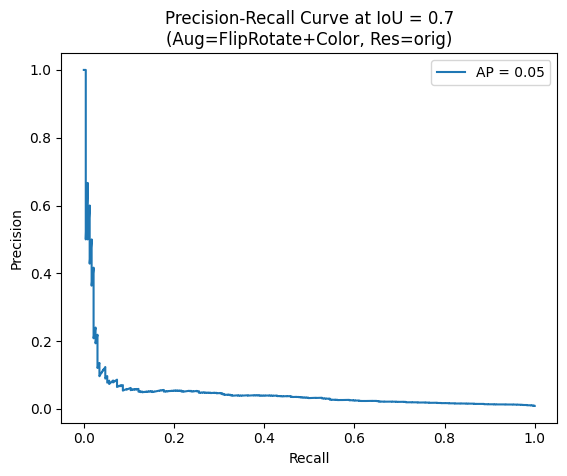

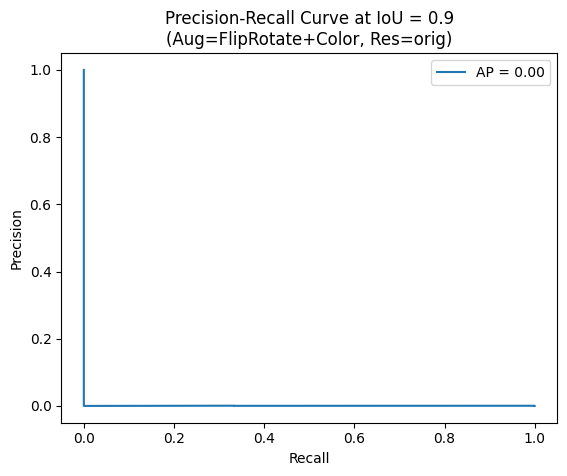

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



[Experiment] Aug=FlipRotate+Color, Res=(300, 300), Epoch=1/5


Validation: 100%|██████████| 34/34 [00:10<00:00,  3.10it/s]


   -> Train Loss=0.9096, Val mAP@0.5=0.0160

[Experiment] Aug=FlipRotate+Color, Res=(300, 300), Epoch=2/5


Validation: 100%|██████████| 34/34 [00:10<00:00,  3.15it/s]


   -> Train Loss=0.7882, Val mAP@0.5=0.0204

[Experiment] Aug=FlipRotate+Color, Res=(300, 300), Epoch=3/5


Validation: 100%|██████████| 34/34 [00:10<00:00,  3.18it/s]


   -> Train Loss=0.7640, Val mAP@0.5=0.0279

[Experiment] Aug=FlipRotate+Color, Res=(300, 300), Epoch=4/5


Validation: 100%|██████████| 34/34 [00:10<00:00,  3.21it/s]


   -> Train Loss=0.7549, Val mAP@0.5=0.0345

[Experiment] Aug=FlipRotate+Color, Res=(300, 300), Epoch=5/5


Validation: 100%|██████████| 34/34 [00:10<00:00,  3.25it/s]


   -> Train Loss=0.7519, Val mAP@0.5=0.0352


Validation: 100%|██████████| 34/34 [00:10<00:00,  3.22it/s]


   [Val@conf=0.3] mAP_0.5=0.0457, AP=0.0679, FP=9439, FN=6063
   [Val@conf=0.5] mAP_0.5=0.1227, AP=0.0876, FP=941, FN=6506
   [Val@conf=0.7] mAP_0.5=0.1791, AP=-0.0000, FP=3, FN=6586

Plotting Precision-Recall Curves for different IoU thresholds:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


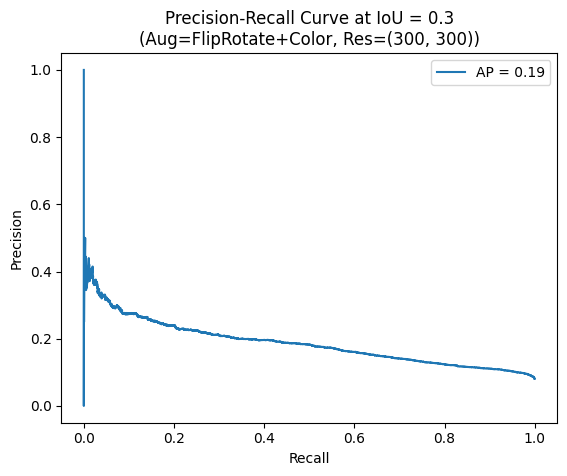

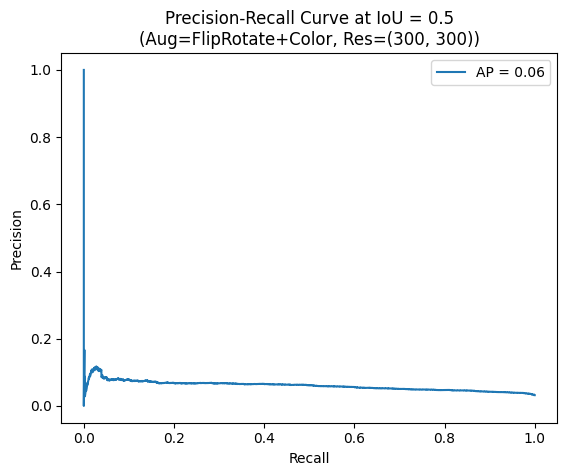

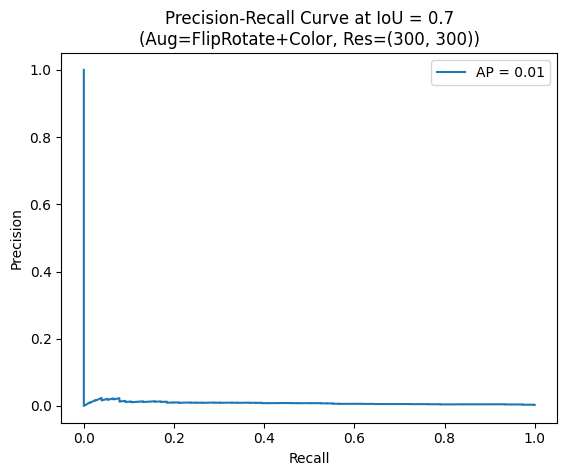

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


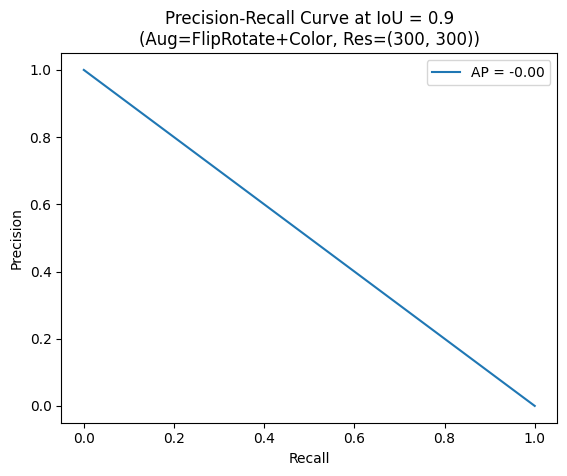

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



[Experiment] Aug=FlipRotate+Color, Res=(512, 512), Epoch=1/5


Validation: 100%|██████████| 34/34 [00:14<00:00,  2.30it/s]


   -> Train Loss=0.9576, Val mAP@0.5=0.0182

[Experiment] Aug=FlipRotate+Color, Res=(512, 512), Epoch=2/5


Validation: 100%|██████████| 34/34 [00:14<00:00,  2.33it/s]


   -> Train Loss=0.7809, Val mAP@0.5=0.0264

[Experiment] Aug=FlipRotate+Color, Res=(512, 512), Epoch=3/5


Validation: 100%|██████████| 34/34 [00:14<00:00,  2.35it/s]


   -> Train Loss=0.7508, Val mAP@0.5=0.0293

[Experiment] Aug=FlipRotate+Color, Res=(512, 512), Epoch=4/5


Validation: 100%|██████████| 34/34 [00:14<00:00,  2.33it/s]


   -> Train Loss=0.7306, Val mAP@0.5=0.0300

[Experiment] Aug=FlipRotate+Color, Res=(512, 512), Epoch=5/5


Validation: 100%|██████████| 34/34 [00:14<00:00,  2.32it/s]


   -> Train Loss=0.7162, Val mAP@0.5=0.0346


Validation: 100%|██████████| 34/34 [00:14<00:00,  2.34it/s]


   [Val@conf=0.3] mAP_0.5=0.0366, AP=0.0683, FP=18246, FN=7796
   [Val@conf=0.5] mAP_0.5=0.0760, AP=0.0785, FP=7626, FN=8062
   [Val@conf=0.7] mAP_0.5=0.2138, AP=0.1009, FP=85, FN=8522

Plotting Precision-Recall Curves for different IoU thresholds:


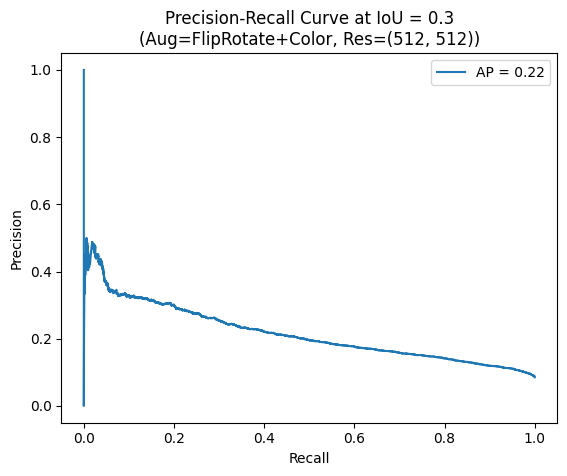

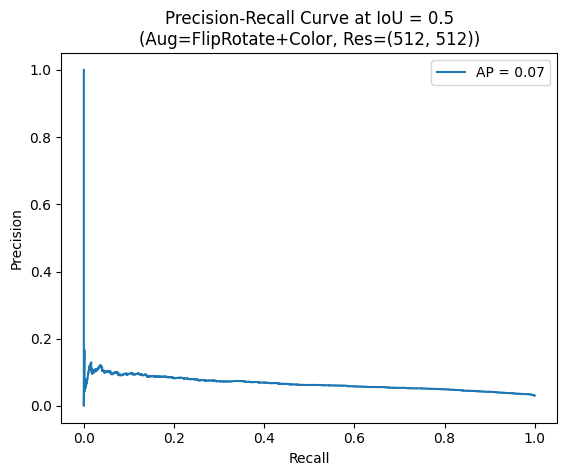

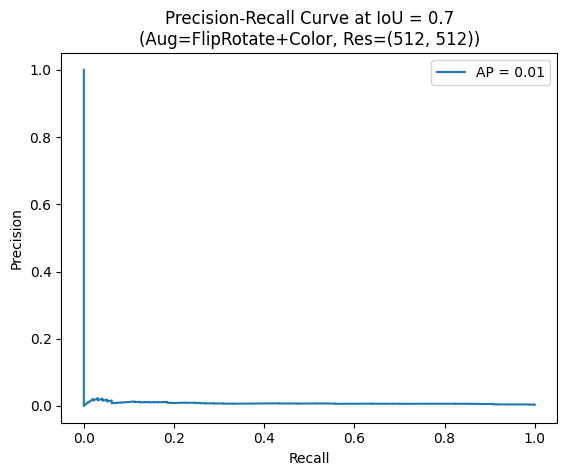

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


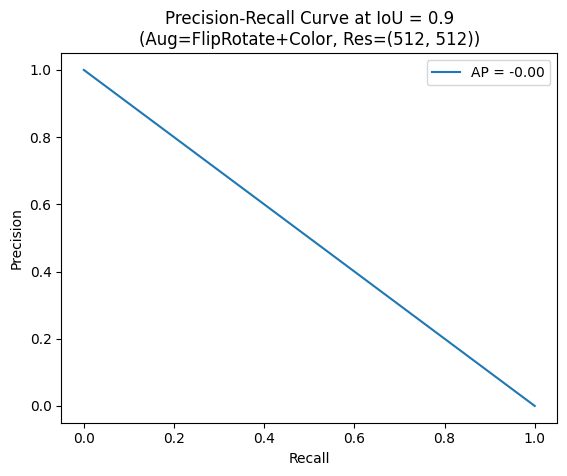


======================== EXPERIMENT RESULTS ========================
{'Aug': 'NoAug', 'Resolution': 'orig', 'ConfThr': 0.3, 'mAP_0.5': 0.053099447760856684, 'AP_0.5': 0.09805276539468613, 'FP': 17076, 'FN': 7916}
{'Aug': 'NoAug', 'Resolution': 'orig', 'ConfThr': 0.5, 'mAP_0.5': 0.06811000622523834, 'AP_0.5': 0.11253079068395624, 'FP': 8256, 'FN': 8218}
{'Aug': 'NoAug', 'Resolution': 'orig', 'ConfThr': 0.7, 'mAP_0.5': 0.19845021494228557, 'AP_0.5': 0.18517355160991583, 'FP': 379, 'FN': 8811}
{'Aug': 'NoAug', 'Resolution': '(300, 300)', 'ConfThr': 0.3, 'mAP_0.5': 0.047473540454634235, 'AP_0.5': 0.09822297732145824, 'FP': 11492, 'FN': 5969}
{'Aug': 'NoAug', 'Resolution': '(300, 300)', 'ConfThr': 0.5, 'mAP_0.5': 0.06472028143167784, 'AP_0.5': 0.11207619605611216, 'FP': 4877, 'FN': 6154}
{'Aug': 'NoAug', 'Resolution': '(300, 300)', 'ConfThr': 0.7, 'mAP_0.5': 0.14985473776117111, 'AP_0.5': 0.14949423187758598, 'FP': 405, 'FN': 6529}
{'Aug': 'NoAug', 'Resolution': '(512, 512)', 'ConfThr': 0.

In [12]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.detection import FasterRCNN
from torchvision.models import resnet34
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import MultiScaleRoIAlign
from torchvision.transforms import ColorJitter, ToTensor
from PIL import Image, ImageOps
from tqdm import tqdm
from sklearn.metrics import precision_recall_curve, average_precision_score
import cv2
from skimage.morphology import remove_small_objects
from skimage.measure import regionprops
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage

def iou(boxA, boxB):
    """
    Calculates Intersection over Union (IoU) between two boxes in [x1, y1, x2, y2] format.
    """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    if interArea == 0:
        return 0.0
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    return interArea / float(boxAArea + boxBArea - interArea)

def compute_map(predictions, ground_truths, iou_threshold=0.5):
    """
    Computes the mean Average Precision (mAP) at a given IoU threshold.
    """
    all_ap = []
    for pred, gt in zip(predictions, ground_truths):
        pred_boxes = pred['boxes'].cpu().numpy() if len(pred['boxes']) > 0 else np.array([])
        pred_scores = pred['scores'].cpu().numpy() if 'scores' in pred and len(pred['scores']) > 0 else np.array([])
        gt_boxes = gt['boxes'].cpu().numpy() if len(gt['boxes']) > 0 else np.array([])
        if len(pred_boxes) == 0:
            if len(gt_boxes) == 0:
                all_ap.append(1.0)
            else:
                all_ap.append(0.0)
            continue
        sorted_indices = np.argsort(pred_scores)[::-1]
        pred_boxes = pred_boxes[sorted_indices]
        pred_scores = pred_scores[sorted_indices]

        tps, fps = [], []
        detected_gt = set()
        for pb in pred_boxes:
            match_found = False
            for j, gb in enumerate(gt_boxes):
                if j in detected_gt:
                    continue
                if iou(pb, gb) >= iou_threshold:
                    tps.append(1)
                    fps.append(0)
                    detected_gt.add(j)
                    match_found = True
                    break
            if not match_found:
                tps.append(0)
                fps.append(1)

        tps = np.cumsum(tps)
        fps = np.cumsum(fps)
        precision = tps / (tps + fps + 1e-6)
        recall = tps / (len(gt_boxes) + 1e-6)
        
        recall_points = np.linspace(0, 1, 101)
        precision_at_recall = np.interp(recall_points, recall, precision)
        ap = np.trapz(precision_at_recall, recall_points)
        all_ap.append(ap)
    return np.mean(all_ap) if len(all_ap) > 0 else 0.0

def evaluate_detections(predictions, ground_truths, iou_threshold):
    """
    Returns a list of scores and a list of binary labels (TP=1, FP=0)
    used for precision-recall curve computations.
    """
    all_scores = []
    all_labels = []
    for pred, gt in zip(predictions, ground_truths):
        pred_boxes = pred["boxes"].cpu().numpy() if len(pred["boxes"]) > 0 else np.array([])
        pred_scores = pred["scores"].cpu().numpy() if "scores" in pred and len(pred["scores"]) > 0 else np.array([])
        gt_boxes = gt["boxes"].cpu().numpy() if len(gt["boxes"]) > 0 else np.array([])

        gt_matched = [False] * len(gt_boxes)
        for i in range(len(pred_boxes)):
            score = pred_scores[i]
            pb = pred_boxes[i]
            match_found = False
            for j, gb in enumerate(gt_boxes):
                if gt_matched[j]:
                    continue
                if iou(pb, gb) >= iou_threshold:
                    match_found = True
                    gt_matched[j] = True
                    break
            all_scores.append(score)
            all_labels.append(1 if match_found else 0)
    
    return np.array(all_scores), np.array(all_labels)

def count_fp_fn(predictions, ground_truths, iou_threshold):
    """
    Computes total False Positives (FP) and False Negatives (FN) at a given IoU threshold.
    """
    total_fp = 0
    total_fn = 0
    for pred, gt in zip(predictions, ground_truths):
        pred_boxes = pred["boxes"].cpu().numpy() if len(pred["boxes"]) > 0 else np.array([])
        gt_boxes = gt["boxes"].cpu().numpy() if len(gt["boxes"]) > 0 else np.array([])
        gt_matched = [False] * len(gt_boxes)

        fp = 0
        for pb in pred_boxes:
            match_found = False
            for j, gb in enumerate(gt_boxes):
                if gt_matched[j]:
                    continue
                if iou(pb, gb) >= iou_threshold:
                    match_found = True
                    gt_matched[j] = True
                    break
            if not match_found:
                fp += 1

        fn = len(gt_boxes) - sum(gt_matched)
        total_fp += fp
        total_fn += fn
    
    return total_fp, total_fn

def filter_predictions_by_confidence(predictions, threshold):
    """
    Filters model predictions by a given confidence (score) threshold.
    Returns a new list of predictions with boxes, labels, and scores above the threshold.
    """
    filtered = []
    for pred in predictions:
        if "scores" not in pred or len(pred["scores"]) == 0:
            filtered.append({"boxes": torch.zeros((0,4)), "labels": torch.zeros((0,)), "scores": torch.zeros((0,))})
            continue
        
        scores = pred["scores"]
        mask = scores >= threshold
        filtered_boxes = pred["boxes"][mask]
        filtered_labels = pred["labels"][mask]
        filtered_scores = scores[mask]
        filtered.append({
            "boxes": filtered_boxes,
            "labels": filtered_labels,
            "scores": filtered_scores
        })
    return filtered

class FruitDetectionDataset(Dataset):
    def __init__(
        self, 
        image_dir, 
        mask_dir, 
        file_list=None, 
        transform=None,
        do_flip_rotate=False, 
        do_color_jitter=False,
        target_resolution=None,    # e.g., (300, 300) or (512, 512) or None
        min_object_size=1
    ):
        """
        Args:
            image_dir (str): Directory containing images.
            mask_dir (str): Directory containing corresponding masks.
            file_list (list, optional): List of filenames to use.
            transform (callable, optional): Transform for images (e.g., ToTensor()).
            do_flip_rotate (bool): Apply random flipping & rotation.
            do_color_jitter (bool): Apply random color jitter.
            target_resolution (tuple): Resize images to this (width, height) if not None.
            min_object_size (int): Minimum size to filter small objects.
        """
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        if file_list is not None:
            self.image_files = file_list
        else:
            self.image_files = sorted(os.listdir(image_dir))
            
        self.transform = transform
        self.do_flip_rotate = do_flip_rotate
        self.do_color_jitter = do_color_jitter
        self.target_resolution = target_resolution
        self.min_object_size = min_object_size
        
        self.color_jitter_transform = None
        if self.do_color_jitter:
            self.color_jitter_transform = ColorJitter(
                brightness=0.2, 
                contrast=0.2, 
                saturation=0.2, 
                hue=0.1
            )

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        filename = self.image_files[idx]
        image_path = os.path.join(self.image_dir, filename)
        mask_path = os.path.join(self.mask_dir, filename)

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.target_resolution is not None:
            image = image.resize(self.target_resolution, Image.BILINEAR)
            mask = mask.resize(self.target_resolution, Image.NEAREST)

        if self.do_flip_rotate:
            image, mask = self.apply_geometric_transforms(image, mask)
        
        if self.color_jitter_transform is not None:
            image = self.color_jitter_transform(image)

        if self.transform:
            image = self.transform(image)
        else:
            image = ToTensor()(image)

        mask_np = np.array(mask)
        boxes = self.masks_to_boxes(mask_np)
        boxes_converted = [[x, y, x + w, y + h] for (x, y, w, h) in boxes]

        if len(boxes_converted) == 0:
            boxes_tensor = torch.zeros((0, 4), dtype=torch.float32)
            labels_tensor = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes_tensor = torch.as_tensor(boxes_converted, dtype=torch.float32)
            labels_tensor = torch.ones((boxes_tensor.shape[0],), dtype=torch.int64)

        target = {
            "boxes": boxes_tensor,
            "labels": labels_tensor,
            "image_id": torch.tensor([idx])
        }
        return image, target

    def apply_geometric_transforms(self, image, mask):
        if random.random() < 0.5:
            image = ImageOps.mirror(image)
            mask = ImageOps.mirror(mask)
        if random.random() < 0.5:
            image = ImageOps.flip(image)
            mask = ImageOps.flip(mask)
        angle = random.choice([0, 90, 180, 270])
        if angle != 0:
            image = image.rotate(angle, expand=True)
            mask = mask.rotate(angle, expand=True)
        return image, mask

    def masks_to_boxes(self, mask_np):
        bin_mask = (mask_np > 10).astype(np.uint8)
        bin_mask = remove_small_objects(bin_mask.astype(bool), min_size=self.min_object_size)
        bin_mask = bin_mask.astype(np.uint8)
        dist = ndimage.distance_transform_edt(bin_mask)
        local_max_coords = peak_local_max(dist, footprint=np.ones((3, 3)), labels=bin_mask)
        local_max_mask = np.zeros(dist.shape, dtype=bool)
        local_max_mask[tuple(local_max_coords.T)] = True
        markers, _ = ndimage.label(local_max_mask)
        labels_ws = watershed(-dist, markers, mask=bin_mask)
        boxes = []
        for region in regionprops(labels_ws):
            min_row, min_col, max_row, max_col = region.bbox
            w = max_col - min_col
            h = max_row - min_row
            if w <= 0 or h <= 0:
                continue
            boxes.append((min_col, min_row, w, h))
        boxes = self.apply_nms(boxes, iou_threshold=0.5)
        return boxes

    def apply_nms(self, boxes, iou_threshold=0.5):
        if not boxes:
            return []
        scores = [1.0] * len(boxes)
        boxes_list = [list(b) for b in boxes]
        idxs = cv2.dnn.NMSBoxes(boxes_list, scores, score_threshold=0.0, nms_threshold=iou_threshold)
        if len(idxs) == 0:
            return []
        if isinstance(idxs[0], (list, tuple)):
            idxs = [i[0] for i in idxs]
        filtered_boxes = [boxes_list[i] for i in idxs]
        return filtered_boxes

def get_faster_rcnn_resnet34(num_classes):
    """
    Creates a Faster-RCNN model with a ResNet-34 backbone.
    """
    backbone_base = resnet34(pretrained=True)
    backbone = nn.Sequential(*list(backbone_base.children())[:-2])
    backbone.out_channels = 512
    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128),),  
        aspect_ratios=((0.8, 1.0, 1.25),)
    )
    roi_pooler = MultiScaleRoIAlign(
        featmap_names=['0'],
        output_size=7,
        sampling_ratio=2
    )
    model = FasterRCNN(
        backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler,
        box_detections_per_img=200
    )
    return model

def collate_fn(batch):
    return tuple(zip(*batch))

def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10):
    model.train()
    total_loss = 0.0
    pbar = tqdm(enumerate(data_loader), total=len(data_loader), desc=f"Epoch {epoch} Training")
    for i, (images, targets) in pbar:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        total_loss += losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if i % print_freq == 0:
            pbar.set_postfix(loss=f"{losses.item():.4f}")
    avg_loss = total_loss / len(data_loader)
    return avg_loss

@torch.no_grad()
def validate(model, data_loader, device):
    model.eval()
    all_preds, all_gts = [], []
    for images, targets in tqdm(data_loader, total=len(data_loader), desc="Validation"):
        images = [img.to(device) for img in images]
        preds = model(images)
        all_preds.extend(preds)
        all_gts.extend(targets)
    return all_preds, all_gts

def run_experiments(train_image_dir, train_mask_dir, val_ratio=0.2, batch_size=4, base_lr=0.005, num_epochs=5, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    all_files = sorted(os.listdir(train_image_dir))
    num_train = int(len(all_files) * (1 - val_ratio))
    train_files = all_files[:num_train]
    val_files = all_files[num_train:]
    base_transform = transforms.Compose([ToTensor()])
    augmentation_configs = [
        {"name": "NoAug", "do_flip_rotate": False, "do_color_jitter": False},
        {"name": "FlipRotate", "do_flip_rotate": True, "do_color_jitter": False},
        {"name": "FlipRotate+Color", "do_flip_rotate": True, "do_color_jitter": True},
    ]
    resolutions = [None, (300, 300), (512, 512)]
    confidence_thresholds = [0.3, 0.5, 0.7]
    results = []
    
    # Loop over augmentation configs and resolutions
    for aug_cfg in augmentation_configs:
        for res in resolutions:
            train_dataset = FruitDetectionDataset(
                image_dir=train_image_dir,
                mask_dir=train_mask_dir,
                file_list=train_files,
                transform=base_transform,
                do_flip_rotate=aug_cfg["do_flip_rotate"],
                do_color_jitter=aug_cfg["do_color_jitter"],
                target_resolution=res
            )
            val_dataset = FruitDetectionDataset(
                image_dir=train_image_dir,
                mask_dir=train_mask_dir,
                file_list=val_files,
                transform=base_transform,
                do_flip_rotate=False,
                do_color_jitter=False,
                target_resolution=res
            )

            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
            
            # Build and train model
            model = get_faster_rcnn_resnet34(num_classes=2)
            model.to(device)
            optimizer = torch.optim.SGD(model.parameters(), lr=base_lr, momentum=0.9, weight_decay=0.0005)

            for epoch in range(1, num_epochs + 1):
                print(f"\n[Experiment] Aug={aug_cfg['name']}, Res={res}, Epoch={epoch}/{num_epochs}")
                train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch)
                val_preds, val_gts = validate(model, val_loader, device)
                val_map = compute_map(val_preds, val_gts, iou_threshold=0.5)
                print(f"   -> Train Loss={train_loss:.4f}, Val mAP@0.5={val_map:.4f}")
                
            # Final evaluation for this experiment configuration
            val_preds, val_gts = validate(model, val_loader, device)
            
            # Loop over confidence thresholds (printing metrics)
            for conf_thr in confidence_thresholds:
                filtered_preds = filter_predictions_by_confidence(val_preds, conf_thr)
                map_05 = compute_map(filtered_preds, val_gts, iou_threshold=0.5)
                scores, labels = evaluate_detections(filtered_preds, val_gts, iou_threshold=0.5)
                if len(scores) > 0:
                    precision, recall, _ = precision_recall_curve(labels, scores)
                    ap = average_precision_score(labels, scores)
                else:
                    precision, recall, ap = [0], [0], 0.0
                    
                total_fp, total_fn = count_fp_fn(filtered_preds, val_gts, iou_threshold=0.5)
                
                result_dict = {
                    "Aug": aug_cfg["name"],
                    "Resolution": "orig" if res is None else f"{res}",
                    "ConfThr": conf_thr,
                    "mAP_0.5": map_05,
                    "AP_0.5": ap,
                    "FP": total_fp,
                    "FN": total_fn
                }
                results.append(result_dict)
                print(f"   [Val@conf={conf_thr}] mAP_0.5={map_05:.4f}, AP={ap:.4f}, FP={total_fp}, FN={total_fn}")
            
            # ---- NEW: Plot Precision-Recall curves for different IoU thresholds ----
            iou_thresholds = [0.3, 0.5, 0.7, 0.9]
            print("\nPlotting Precision-Recall Curves for different IoU thresholds:")
            for iou_thr in iou_thresholds:
                scores, labels = evaluate_detections(val_preds, val_gts, iou_threshold=iou_thr)
                if len(scores) > 0:
                    precision, recall, _ = precision_recall_curve(labels, scores)
                    ap = average_precision_score(labels, scores)
                    plt.figure()
                    plt.plot(recall, precision, label=f'AP = {ap:.2f}')
                    plt.xlabel('Recall')
                    plt.ylabel('Precision')
                    plt.title(f'Precision-Recall Curve at IoU = {iou_thr}\n(Aug={aug_cfg["name"]}, Res={"orig" if res is None else res})')
                    plt.legend()
                    plt.show()
            
    print("\n======================== EXPERIMENT RESULTS ========================")
    for r in results:
        print(r)
    print("==================================================================\n")
    return results

# Paths to your dataset images and masks
TRAIN_DATASET_IMAGE_PATH = "/kaggle/input/cv-a3q2/Q2/detection/train/images"
TRAIN_DATASET_MASK_PATH  = "/kaggle/input/cv-a3q2/Q2/detection/train/masks"

# Run experiments
final_results = run_experiments(
    train_image_dir=TRAIN_DATASET_IMAGE_PATH,
    train_mask_dir=TRAIN_DATASET_MASK_PATH,
    val_ratio=0.2,
    batch_size=4,
    base_lr=0.005,
    num_epochs=5
)
